In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
import enum

os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
from spacepy import pycdf
from pathlib import Path
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime as dt

In [64]:
# Read hdf files. 
# file name should contain complete path to the file
def readH5File(fileName):
    df = pd.DataFrame()
    try:
        df = pd.read_hdf(fileName)
        return df
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    return df
        
# Read txt files. 
# file name should contain complete path to the file       
def readTextFile(fileName):
    try:
        dataFile = open(fileName, 'r')
        txtData = dataFile.read()
        return txtData
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    
    
# Read cdf (common data format). Refer https://cdf.gsfc.nasa.gov/
# Make sure cdf library is installed and CDF_LIB path is defined
# Link : https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/cdf38_0/windows/
# os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
# Make sure pycdf libray is installed
def readCDFFile(fileName):
    try:
        cdfFile = pycdf.CDF(fileName)
        return cdfFile
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
        
def saveToHDFFile(dataframe, filePath):
    try:
        dataframe.to_hdf(filePath, key='df')
    except:
        error = 'Failed to save dataframe: ' + filePath 
        log(error)

In [4]:
# calculates number of days between given dates
# this is used verify there are accurate number of entries in the data set
def numberOfDaysInDates(start, end):
    startDate = datetime.strptime(start, dateFormat)
    endDate = datetime.strptime(end, dateFormat)
    delta = endDate - startDate
    return delta.days + 1


# An empty dataframe is initialised with the given metadata
# attribute name in metadata is used to create the column names
def initDataFrame(metadata):
    columnNames = []
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        columnNames.append(attribute)   
        
    df = pd.DataFrame(columns=columnNames)
    return df


# extract data values from text lines based on the given meta data
# metadata comprises what is the data, type of the data and positions need to be extracted
# Threshold value: if the attribute value goes beyond thresold value then it is considered as NaN
def extractDataFromTxtLine(txt, metadata):
    value = {}
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        startPosition = element[_start_position] if _start_position in element else 0
        endPosition = element[_end_position] if _end_position in element else 0
        thresholdValue = element[_threshold_value] if _threshold_value in element else 0
        dataDateFormat = element[_date_format] if _date_format in element else None
        try:
            attrValue = txt[startPosition:endPosition]
            if attrValue == '':
                break
            if thresholdValue != 0:
                try:
                    attrValue = float(attrValue)
                    attrValue = float('NaN') if attrValue <= 0 else attrValue
                    # checks attribute value goes above threshold value. if goes beyod invalidate
                    if attrValue > thresholdValue:
                        attrValue = float('NaN')
                except:
                    attrValue = float('NaN')
                    error = 'Value cannot be converted to float'
                    log(error)
            value[attribute] = attrValue
        except:
            error = 'No data available at this position'
            log(error)
    return value


# make date formats in data to yyyy-mm-dd
# remove redundant datas
# add values to time series from start date to end date if any entries are missing
def cleanAndFormatData(data, metadata):
    dataDateFormat = None
    for element in metadata:
        dataDateFormat = element[_date_format] if _date_format in element else None
    # set date format to yyyy-mm-dd
    data[_date] = pd.to_datetime(data[_date], format=dataDateFormat)
    
    # extract data only inbetween start date and end date(analysis time period)
    data = data[(data[_date] >= startDate) & (data[_date] <= endDate)]
    
    
    # set date as index for the dataframe
    data = data.set_index(_date)
    
    # remove duplicates
    data = data[~data.index.duplicated(keep='first')]
    
    #check final data set has accurate number of entries
    dataLength = data.shape[0]
    if dataLength != numberOfDays:
        error = 'Number of entries mismatch. Check data'
        log(error)
        log('Automatic index correction')
        data = fillTimeSeries(data)
    return data


# fill time series index if any dates are missing
# index is filled by a start date and end date. 
# It will check for any date missing between start and end date.
# Creates series from start and end date then reindex the original data set with the date series.
# fills NaN for missing values
def fillTimeSeries(data):
    strSDate = datetime.strptime(startDate, '%Y-%m-%d')
    strEDate = datetime.strptime(endDate, '%Y-%m-%d')
    timeSeries = pd.DataFrame({ _date: pd.Series([strSDate, strEDate])})
    timeSeries.set_index(_date, inplace=True)
    data = data.append(timeSeries)
    idx = pd.date_range(min(data.index), max(data.index))
    data = data[~data.index.duplicated(keep='first')]
    data = data.reindex(idx, fill_value=float('NaN'))
    return data


# Fills missing values by interpolation. 
def fillNaNValueWithInterpolation(data, column):
    data[column] = data[column].interpolate()
    data[column].head(4)
    
    return data


# calculate moving average with a window
# window size is 27 and minimum period is 17
def calculateMovingAvg(data, valueColumn, movingAvgColumn):
    data[movingAvgColumn] = data[valueColumn].rolling(window=windowSize, min_periods=windowSize-10).mean()
    return data


# calculate relative difference of original value and moving average value
def calculateRelativeDifference(data, valueColumn, movingAvgColumn, relDiffColumn):
    data[relDiffColumn] = ((data[valueColumn] - data[movingAvgColumn])/data[movingAvgColumn])*100
    return data

def getStartAndEndDateOfYear(year):
    first_day_of_year = str(year) + '-01-01'
    last_day_of_year = str(year) + '-12-31'
    
    return (first_day_of_year, last_day_of_year)


In [72]:
startYear = 1997
endYear = 2020
startDate = str(startYear) + '-01-01'
endDate = str(endYear) + '-12-31'
analysisPeriod = np.arange(startYear, endYear+1)
dateFormat = '%Y-%m-%d'
numberOfDays = numberOfDaysInDates(startDate, endDate)

f10_7_max_value = 300
sws_max_value = 900

windowSize = 27
minPeriod = 20

_attribute = 'attribute'
_start_position = 'start_position'
_end_position = 'end_position'
_date = 'date'
_threshold_value = 'threshold_value'
_date_format = 'date_format'

# ------------------f10.7 variables
_f10_7 = 'f10_7'
_f10_7_ma_27 = 'f10_7_ma_27'
_f10_7_rel_diff = 'f10_7_diff_rel'

# ------------------solar wind speed variables
_sws = 'sws'
_sws_ma_27 = 'sws_ma_27'
_sws_rel_diff = 'sws_diff_rel'

#-------------------total electron content variables


# final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/Final Plot/'

final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/correlation_analysis_01122022/result_plots_2/'

In [6]:
F10_7_FOLDER = "C:/Users/davi_fr/Documents/Project/data/F10.7cm radiofluxindex/"

# dataPosition variable contain how to extarct data from string based on position and length
# format: [[attribure, start_position, end_position, threshold_value, date_format],...]
# threshold value: 
f10_7DataPosition = [{_attribute: _date, _start_position: 0,  _end_position: 10},
                {_attribute: _f10_7, 
                 _start_position: 149, 
                 _end_position: 156, 
                 _threshold_value: f10_7_max_value, 
                 _date_format: None}]




f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/f10_7/f10_7.h5'
sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/sws/sws.h5'

In [6]:
def writeToLogFile(log):
    dt = datetime.now()
    log = str(dt) + '\t' + log + '\n' 
    file_name = 'log_file.txt'
    f = open(file_name, 'a+')  # open file in append mode
    f.write(log)
    f.close()

def log(message):
    writeToLogFile(message)
#     print(message)

In [7]:
testLatitudes = np.arange(-87.5, 90, 2.5)
print(testLatitudes)

[-87.5 -85.  -82.5 -80.  -77.5 -75.  -72.5 -70.  -67.5 -65.  -62.5 -60.
 -57.5 -55.  -52.5 -50.  -47.5 -45.  -42.5 -40.  -37.5 -35.  -32.5 -30.
 -27.5 -25.  -22.5 -20.  -17.5 -15.  -12.5 -10.   -7.5  -5.   -2.5   0.
   2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5  30.
  32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5  60.
  62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5]


In [8]:
tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec"
tec_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og"

tecRelDiffColumnName = "tec_rel_diff_lat_"
tecColumnName = "tec_lat_"

In [9]:


def getTECDataAtLatitude(latitude):
    

    tec_data = pd.DataFrame()
    for year in analysisPeriod:
        tec_file_path = tec_rel_diff + "\\" + str(year) + ".h5"
        tec_og_file_path = tec_file + "\\" + str(year) + ".h5"

        tecData = readH5File(tec_file_path)
        tecOGData = readH5File(tec_og_file_path)

        tecData = pd.DataFrame(tecData[[latitude]].mean(axis=1).groupby(level='date').mean())
        tecOGData = pd.DataFrame(tecOGData[[latitude]].mean(axis=1).groupby(level='date').mean())


        tecData.columns = [tecRelDiffColumnName+str(latitude)]
        tecData[tecColumnName+str(latitude)] = tecOGData
        tecData.index =  pd.to_datetime(tecData.index, format='%Y-%m-%d')
        tec_data = tec_data.append(tecData)
    return tec_data

# tec_data = getTECDataAtLatitude(0)    
# print(tec_data)

In [21]:
f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"
f10_7_rel_diff = readH5File(f10_7_rel_diff_file)

f10_7_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
f10_7Data = readH5File(f10_7_file)
f10_7Data['f10_7_rel_diff'] = f10_7_rel_diff['f10_7']
print(f10_7Data)

sws_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
sws_rel_diff = readH5File(sws_rel_diff_file)


sws_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
swsData = readH5File(sws_file)
swsData['sws_rel_diff'] = sws_rel_diff['sws']
print(swsData)


            f10_7  f10_7_rel_diff
date                             
1997-01-01   70.0             NaN
1997-01-02   69.7             NaN
1997-01-03   70.8             NaN
1997-01-04   71.4             NaN
1997-01-05   71.9             NaN
...           ...             ...
2020-12-27   84.9        0.258048
2020-12-28   84.3        0.290813
2020-12-29   81.4       -2.276567
2020-12-30   80.1       -2.983133
2020-12-31   78.5       -4.298551

[8766 rows x 2 columns]
               sws  sws_rel_diff
1997-01-01     NaN           NaN
1997-01-02     NaN           NaN
1997-01-03     NaN           NaN
1997-01-04     NaN           NaN
1997-01-05     NaN           NaN
...            ...           ...
2020-12-27  463.09     17.168871
2020-12-28  486.17     22.138036
2020-12-29  467.50     16.778766
2020-12-30  478.41     18.260138
2020-12-31  398.60     -1.849074

[8766 rows x 2 columns]


In [114]:
def calculateCorrelationWithWindow(latitude, tec_data, f10_7Data, swsData):
    correlation_window = pd.DataFrame(columns=['window_size', 'correlation_tec_f10_7_og', 'correlation_f10_7_rel_diff', 'correlation_sws_rel_diff'])
    for windowSize in np.arange(1, 8766):
        
        correlation_tec_f10_7_og = tec_data[tecColumnName+str(latitude)].rolling(windowSize).corr(f10_7Data['f10_7']).mean()
        correlation_f10_7_rel_diff = tec_data[tecRelDiffColumnName+str(latitude)].rolling(windowSize).corr(f10_7Data['f10_7_rel_diff']).mean()
        correlation_sws_rel_diff = tec_data[tecRelDiffColumnName+str(latitude)].rolling(windowSize).corr(swsData['sws_rel_diff']).mean()
        correlation_sws_og = tec_data[tecColumnName+str(latitude)].rolling(windowSize).corr(swsData['sws']).mean()

        row = {'window_size': windowSize, 
               'correlation_tec_f10_7_og': correlation_tec_f10_7_og, 
               'correlation_f10_7_rel_diff': correlation_f10_7_rel_diff, 
               'correlation_sws_rel_diff':correlation_sws_rel_diff,
               'correlation_sws_og':correlation_sws_og
              }
        correlation_window = correlation_window.append(row, ignore_index=True)
#     print(correlation_window)  

    correlation_window.set_index('window_size', inplace = True)
    fileName = "window_size_" + str(latitude) + ".h5"
    df.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/correlation_window_size/" + fileName, key= 'df')
    return correlation_window


# correlation_window = calculateCorrelationWithWindow(0, tec_data, f10_7Data, swsData)

In [ ]:
df = correlation_window[['correlation_tec_f10_7_og', 'correlation_f10_7_rel_diff', 'correlation_sws_rel_diff']]
# df = df[0:100]
ax = df.plot(figsize=(12, 5))
lgd = ax.legend(['Mean Correlation Coefficient; TEC X F10.7',
           'Mean Correlation Coefficient; Relative Difference TEC X F10.7',
           'Mean Correlation Coefficient; Relative Difference TEC X Solar Wind Speed',
           'Mean Correlation Coefficient; TEC X Solar Wind Speed'], 
          bbox_to_anchor= (1, -0.2))

plt.title('Mean correlation coefficient at 0 degree latitude X Correlation Window Size', pad=20)
ax.set_xlabel("Window Size")
ax.set_ylabel("Correlation Coefficient")
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='x' )
ax.grid('on', which='minor', axis='y' )
ax.grid('on', which='major', axis='y' )

minorLocator = MultipleLocator(500)
# majorLocator = MultipleLocator(900)
ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(minorLocator)
# correlation_window.max()

# df.to_excel("correlation_window_size.xlsx") 

plt.savefig('Mean correlation coefficient at 0 degree latitude X Correlation Window Size.jpg',
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight', dpi= 200)

In [ ]:
testLatitudes = np.arange(-87.5, 90, 2.5)
for latitude in testLatitudes:
    print('______________' + str(latitude) + '_______________')
    tec_data = getTECDataAtLatitude(latitude)
    print('TEC Data Fetched at ' + str(latitude))
    correlation_window = calculateCorrelationWithWindow(latitude, tec_data, f10_7Data, swsData)
    print('Correlation Data saved at ' + str(latitude))
    
#     finalDataFrame = correlation_window
#     currentColumns = finalDataFrame.columns
#     latitudeColumn = [latitude]
#     finalDataFrame.columns = pd.MultiIndex.from_product([latitudeColumn, currentColumns], names=['latitude', 'data'])
    
print('end')
    
    

In [ ]:
testLatitudes = np.arange(-87.5, 90, 2.5)

filePath = "C:/Users/davi_fr/Documents/Thesis Project Final/source_code/correlation_window_size/"
finalDataFrame = pd.DataFrame()
for latitude in testLatitudes:
    fileName = "window_size_" + str(latitude) + ".h5"
    file =  filePath + fileName
    dataFile = readH5File(file)
    
    df = dataFile
    currentColumns = df.columns
    latitudeColumn = [latitude]
    df.columns = pd.MultiIndex.from_product([latitudeColumn, currentColumns], names=['latitude', 'data'])
    if finalDataFrame.empty:
        finalDataFrame = df
    else:
        finalDataFrame = finalDataFrame.join(df)
    
# print(finalDataFrame)

In [ ]:
plotsavePath = "C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/"
d = finalDataFrame.iloc[:, finalDataFrame.columns.get_level_values(1)=='correlation_tec_f10_7_og']
plt.figure(figsize=(15, 6))
ax = plt.pcolormesh(d.T, cmap='Reds')
plt.xlabel('WIndow Size')
plt.ylabel('Latitude')
cbar = plt.colorbar()
cbar.set_label('Mean Correlation Coefficient')
plt.title('Mean Correlation Coefficient; TEC X F10.7', pad=20)
indexValues = np.asarray([i[0] for i in d.T.index.values])#d.T.index.values
tiks = range(0,len(d.T.index.values),4)
lbl = indexValues[tiks]
plt.yticks(ticks=tiks, labels=lbl)
fileName = 'Mean Correlation Coefficient TEC X F10.7.jpg'
plt.savefig(plotsavePath + fileName,  
            bbox_inches='tight', dpi= 200)
plt.show()




d = finalDataFrame.iloc[:, finalDataFrame.columns.get_level_values(1)=='correlation_f10_7_rel_diff']
plt.figure(figsize=(15, 6))
plt.pcolormesh(d.T, cmap='Blues')
cbar = plt.colorbar()
plt.xlabel('WIndow Size')
plt.ylabel('Latitude')
cbar.set_label('Mean Correlation Coefficient')
plt.title('Mean Correlation Coefficient; Relative Difference TEC X F10.7', pad=20)
indexValues = np.asarray([i[0] for i in d.T.index.values])#d.T.index.values
tiks = range(0,len(d.T.index.values),4)
lbl = indexValues[tiks]
plt.yticks(ticks=tiks, labels=lbl)
fileName = 'Mean Correlation Coefficient Relative Difference TEC X F10.7.jpg'
plt.savefig(plotsavePath + fileName,  
            bbox_inches='tight', dpi= 200)
plt.show()


d = finalDataFrame.iloc[:, finalDataFrame.columns.get_level_values(1)=='correlation_sws_rel_diff']
plt.figure(figsize=(15, 6))
plt.pcolormesh(d.T, cmap='Greens')
cbar = plt.colorbar()
plt.xlabel('WIndow Size')
plt.ylabel('Latitude')
cbar.set_label('Mean Correlation Coefficient')
plt.title('Mean Correlation Coefficient; Relative Difference TEC X Solar Wind Speed', pad=20)
indexValues = np.asarray([i[0] for i in d.T.index.values])#d.T.index.values
tiks = range(0,len(d.T.index.values),4)
lbl = indexValues[tiks]
plt.yticks(ticks=tiks, labels=lbl)
fileName = 'Mean Correlation Coefficient Relative Difference TEC X Solar Wind Speed.jpg'
plt.savefig(plotsavePath + fileName,  
            bbox_inches='tight', dpi= 200)
plt.show()



True

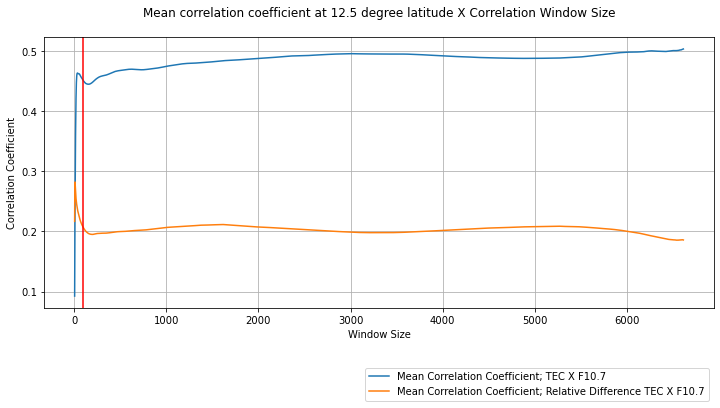

In [12]:

# df = df[0:100]
plotsavePath = "C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/"
def plotCorrWindo(lat, df):
#     df = df[60:200]
    ax = df.plot(figsize=(12, 5))
    lgd = ax.legend(['Mean Correlation Coefficient; TEC X F10.7',
               'Mean Correlation Coefficient; Relative Difference TEC X F10.7',
               'Mean Correlation Coefficient; Relative Difference TEC X Solar Wind Speed',
               'Mean Correlation Coefficient; TEC X Solar Wind Speed'], 
              bbox_to_anchor= (1, -0.2))

    plt.title('Mean correlation coefficient at ' + str(lat) + ' degree latitude X Correlation Window Size', pad=20)
    ax.set_xlabel("Window Size")
    ax.set_ylabel("Correlation Coefficient")
    ax.grid('on', which='minor', axis='x' )
    ax.grid('on', which='major', axis='x' )
    ax.grid('on', which='minor', axis='y' )
    ax.grid('on', which='major', axis='y' )

#     minorLocator = MultipleLocator(500)
    # majorLocator = MultipleLocator(900)
#     ax.xaxis.set_minor_locator(minorLocator)
#     ax.xaxis.set_major_locator(minorLocator)
    # correlation_window.max()

    # df.to_excel("correlation_window_size.xlsx") 
    fileName = 'mean_correlation_plot_' + str(lat) + '_latitude.jpg'
    plt.axvline(x=90, color='r')
    plt.savefig(plotsavePath + fileName,
                bbox_extra_artists=(lgd,), 
                bbox_inches='tight', dpi= 200)
    return True
    
    
#filePath = "C:/Users/davi_fr/Documents/Thesis Project Final/source_code/correlation_window_size/"
file = 'mean_correlation_latitude_all_window_size.h5'
data = readH5File(file)
lat = 12.5
df = data[lat]
df = df[['correlation_f10_7_rel_diff', 'correlation_sws_rel_diff']]
#print(df)
plotCorrWindo(lat, df)

In [ ]:
print(finalDataFrame)
finalDataFrame.to_hdf('mean_correlation_latitude_all_window_size.h5', key='df')
print('saved')

In [65]:
tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\append\\tec\\tec.h5"
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"


f10_7_rel_diff = readH5File(f10_7_rel_diff_file)
tecData = readH5File(tec_rel_diff)[[12.5]]
# print(tecData[[5,22.5, 52.5]])
swsData = readH5File(sws_rel_diff)
binValue = np.arange(-1,1.1,0.1)
correlation_window_bin_with_most_values = pd.DataFrame(columns=['window_size', 'bin_with_most_values', 'actual_bin'])
correlation_window_bin_with_most_values_f10 = pd.DataFrame(columns=['window_size', 'bin_with_most_values', 'actual_bin'])

for windowSize in np.arange(2, len(tecData)):
# for windowSize in np.arange(2, 3):
    
    correlation_tec_sws = tecData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1)
    correlation_tec_f10 = tecData.rolling(windowSize).corr(f10_7_rel_diff['f10_7']).shift(int(windowSize/2)*-1)
#     print(correlation_tec_sws)
    
    
    hist, bins = np.histogram(correlation_tec_sws, bins=binValue)
    hist_f10, bins_f10 = np.histogram(correlation_tec_f10, bins=binValue)
#     print(correlation_tec_sws)
#     hist, bins = plt.hist(correlation_tec_sws, bins=binValue)
    
#     print(hist, bins)
    
    bin_with_most_value = binValue[list(hist).index(hist.max())].round(1)
    actualBin = bins[list(hist).index(hist.max())]
    row = {'window_size': windowSize, 
           'bin_with_most_values': bin_with_most_value,
           'actual_bin': actualBin
          }
    correlation_window_bin_with_most_values = correlation_window_bin_with_most_values.append(row, ignore_index=True)
    
    
    bin_with_most_value_f10 = binValue[list(hist_f10).index(hist_f10.max())].round(1)
    actualBin_f10 = bins_f10[list(hist_f10).index(hist_f10.max())]
    row_f10 = {'window_size': windowSize, 
           'bin_with_most_values': bin_with_most_value_f10,
           'actual_bin': actualBin_f10
          }
    correlation_window_bin_with_most_values_f10 = correlation_window_bin_with_most_values_f10.append(row_f10, ignore_index=True)
    

    print(row)
    
    
# print(len(tecData))
correlation_window_bin_with_most_values= correlation_window_bin_with_most_values.set_index('window_size')
correlation_window_bin_with_most_values_f10= correlation_window_bin_with_most_values_f10.set_index('window_size')

print(correlation_window_bin_with_most_values)
correlation_window_bin_with_most_values.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws_lat_12_5.h5", key= 'df')
correlation_window_bin_with_most_values_f10.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10_lat_12_5.h5", key= 'df')


{'window_size': 2, 'bin_with_most_values': 0.9, 'actual_bin': 0.8999999999999995}
{'window_size': 3, 'bin_with_most_values': 0.9, 'actual_bin': 0.8999999999999995}
{'window_size': 4, 'bin_with_most_values': 0.9, 'actual_bin': 0.8999999999999995}
{'window_size': 5, 'bin_with_most_values': 0.9, 'actual_bin': 0.8999999999999995}
{'window_size': 6, 'bin_with_most_values': 0.8, 'actual_bin': 0.7999999999999996}
{'window_size': 7, 'bin_with_most_values': 0.8, 'actual_bin': 0.7999999999999996}
{'window_size': 8, 'bin_with_most_values': 0.7, 'actual_bin': 0.6999999999999997}
{'window_size': 9, 'bin_with_most_values': 0.7, 'actual_bin': 0.6999999999999997}
{'window_size': 10, 'bin_with_most_values': 0.7, 'actual_bin': 0.6999999999999997}
{'window_size': 11, 'bin_with_most_values': 0.7, 'actual_bin': 0.6999999999999997}
{'window_size': 12, 'bin_with_most_values': 0.6, 'actual_bin': 0.5999999999999996}
{'window_size': 13, 'bin_with_most_values': 0.6, 'actual_bin': 0.5999999999999996}
{'window_siz

{'window_size': 103, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 104, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 105, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 106, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 107, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 108, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 109, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 110, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 111, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 112, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 113, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 114, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999

{'window_size': 211, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 212, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 213, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 214, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 215, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 216, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 217, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 218, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 219, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 220, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 221, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 222, 'bin_with_most_values': 0.2, 'actual_bin': 0

{'window_size': 318, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 319, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 320, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 321, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 322, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 323, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 324, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 325, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 326, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 327, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 328, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 329, 'bin_with_most_values': 0.2, 'actual_bin': 0

{'window_size': 435, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 436, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 437, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 438, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 439, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 440, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 441, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 442, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 443, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 444, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 445, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 446, 'bin_with_most_values': 0.2, 'actual_bin': 0.199

{'window_size': 534, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 535, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 536, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 537, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 538, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 539, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 540, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 541, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 542, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 543, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 544, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 545, 'bin_with_most_values': 0.2, 'actual_bin': 0

{'window_size': 635, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 636, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 637, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 638, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 639, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 640, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 641, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 642, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 643, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 644, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 645, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 646, 'bin_with_most_values': 0.2, 'actual_bin': 0

{'window_size': 736, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 737, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 738, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 739, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 740, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 741, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 742, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 743, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 744, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 745, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 746, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999999997}
{'window_size': 747, 'bin_with_most_values': 0.4, 'actual_bin': 0.3999999999

{'window_size': 833, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 834, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 835, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 836, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 837, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 838, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 839, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 840, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 841, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 842, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 843, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 844, 'bin_with_most_values': 0.2, 'actual_bin': 0

{'window_size': 940, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 941, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 942, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 943, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 944, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 945, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 946, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 947, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 948, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 949, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 950, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 951, 'bin_with_most_values': 0.2, 'actual_bin': 0

{'window_size': 1048, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1049, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1050, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1051, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1052, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1053, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1054, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1055, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1056, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1057, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1058, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1059, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1144, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1145, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1146, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1147, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1148, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1149, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1150, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1151, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1152, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1153, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1154, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1155, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1254, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1255, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1256, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1257, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1258, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1259, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1260, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1261, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1262, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1263, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1264, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1265, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1355, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1356, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1357, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1358, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1359, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1360, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1361, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1362, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1363, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1364, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1365, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1366, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1451, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1452, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1453, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1454, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1455, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1456, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1457, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1458, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1459, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1460, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1461, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1462, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1564, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1565, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1566, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1567, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1568, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1569, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1570, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1571, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1572, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1573, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1574, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1575, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1669, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1670, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1671, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1672, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1673, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1674, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1675, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1676, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1677, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1678, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1679, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1680, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1779, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1780, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1781, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1782, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1783, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1784, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1785, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1786, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1787, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1788, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1789, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1790, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1890, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1891, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1892, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1893, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1894, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1895, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1896, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1897, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1898, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1899, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1900, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 1901, 'bin_with_most_values': 0.2, 'ac

{'window_size': 1988, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1989, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1990, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1991, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1992, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1993, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1994, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1995, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1996, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1997, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1998, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 1999, 'bin_with_most_values': 0.3, 'actual_bin': 

{'window_size': 2085, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2086, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2087, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2088, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2089, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2090, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2091, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2092, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2093, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2094, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2095, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 2096, 'bin_with_most_values': 0.3, 'actual_bin': 

{'window_size': 2184, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2185, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2186, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2187, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2188, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2189, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2190, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2191, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2192, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2193, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2194, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2195, 'bin_with_most_values': 0.2, 'ac

{'window_size': 2284, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2285, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2286, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2287, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2288, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2289, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2290, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2291, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2292, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2293, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2294, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2295, 'bin_with_most_values': 0.2, 'ac

{'window_size': 2398, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2399, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2400, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2401, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2402, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2403, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2404, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2405, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2406, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2407, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2408, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2409, 'bin_with_most_values': 0.2, 'ac

{'window_size': 2496, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2497, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2498, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2499, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2500, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2501, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2502, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2503, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2504, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2505, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2506, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2507, 'bin_with_most_values': 0.2, 'ac

{'window_size': 2611, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2612, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2613, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2614, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2615, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2616, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2617, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2618, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2619, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2620, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2621, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2622, 'bin_with_most_values': 0.2, 'ac

{'window_size': 2719, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2720, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2721, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2722, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2723, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2724, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2725, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2726, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2727, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2728, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2729, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2730, 'bin_with_most_values': 0.2, 'ac

{'window_size': 2834, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2835, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2836, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2837, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2838, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2839, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2840, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2841, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2842, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2843, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2844, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2845, 'bin_with_most_values': 0.2, 'ac

{'window_size': 2933, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2934, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2935, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2936, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2937, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2938, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2939, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2940, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2941, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2942, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2943, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 2944, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3030, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3031, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3032, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3033, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3034, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3035, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3036, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3037, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3038, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3039, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3040, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3041, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3129, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3130, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3131, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3132, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3133, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3134, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3135, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3136, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3137, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3138, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3139, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3140, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3229, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3230, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3231, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3232, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3233, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3234, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3235, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3236, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3237, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3238, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3239, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3240, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3327, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3328, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3329, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3330, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3331, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3332, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3333, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3334, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3335, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3336, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3337, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3338, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3426, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3427, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3428, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3429, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3430, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3431, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3432, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3433, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3434, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3435, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3436, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3437, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3528, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3529, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3530, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3531, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3532, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3533, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3534, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3535, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3536, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3537, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3538, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3539, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3630, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3631, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3632, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3633, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3634, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3635, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3636, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3637, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3638, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3639, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3640, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3641, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3729, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3730, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3731, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3732, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3733, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3734, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3735, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3736, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3737, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3738, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3739, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3740, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3833, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3834, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3835, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3836, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3837, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3838, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3839, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3840, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3841, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3842, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3843, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3844, 'bin_with_most_values': 0.2, 'ac

{'window_size': 3933, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3934, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3935, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3936, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3937, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3938, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3939, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3940, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3941, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3942, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3943, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 3944, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4037, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4038, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4039, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4040, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4041, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4042, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4043, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4044, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4045, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4046, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4047, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4048, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4147, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4148, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4149, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4150, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4151, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4152, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4153, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4154, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4155, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4156, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4157, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4158, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4248, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4249, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4250, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4251, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4252, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4253, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4254, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4255, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4256, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4257, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4258, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4259, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4353, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4354, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4355, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4356, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4357, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4358, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4359, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4360, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4361, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4362, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4363, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4364, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4455, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4456, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4457, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4458, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4459, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4460, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4461, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4462, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4463, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4464, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4465, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4466, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4559, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4560, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4561, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4562, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4563, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4564, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4565, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4566, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4567, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4568, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4569, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4570, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4663, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4664, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4665, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4666, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4667, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4668, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4669, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4670, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4671, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4672, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4673, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4674, 'bin_with_most_values': 0.3, 'actual_bin':

{'window_size': 4762, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4763, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4764, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4765, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4766, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4767, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4768, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4769, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4770, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4771, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4772, 'bin_with_most_values': 0.3, 'actual_bin': 0.2999999999999998}
{'window_size': 4773, 'bin_with_most_values': 0.3, 'actual_bin': 

{'window_size': 4865, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4866, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4867, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4868, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4869, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4870, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4871, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4872, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4873, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4874, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4875, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4876, 'bin_with_most_values': 0.2, 'ac

{'window_size': 4965, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4966, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4967, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4968, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4969, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4970, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4971, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4972, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4973, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4974, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4975, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 4976, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5067, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5068, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5069, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5070, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5071, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5072, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5073, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5074, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5075, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5076, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5077, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5078, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5169, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5170, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5171, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5172, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5173, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5174, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5175, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5176, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5177, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5178, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5179, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5180, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5273, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5274, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5275, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5276, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5277, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5278, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5279, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5280, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5281, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5282, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5283, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5284, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5376, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5377, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5378, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5379, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5380, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5381, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5382, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5383, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5384, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5385, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5386, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5387, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5476, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5477, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5478, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5479, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5480, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5481, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5482, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5483, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5484, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5485, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5486, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5487, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5575, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5576, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5577, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5578, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5579, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5580, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5581, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5582, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5583, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5584, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5585, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5586, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5677, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5678, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5679, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5680, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5681, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5682, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5683, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5684, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5685, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5686, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5687, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5688, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5779, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5780, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5781, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5782, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5783, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5784, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5785, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5786, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5787, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5788, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5789, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5790, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5877, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5878, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5879, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5880, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5881, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5882, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5883, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5884, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5885, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5886, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5887, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5888, 'bin_with_most_values': 0.2, 'ac

{'window_size': 5977, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5978, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5979, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5980, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5981, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5982, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5983, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5984, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5985, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5986, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5987, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 5988, 'bin_with_most_values': 0.2, 'ac

{'window_size': 6082, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6083, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6084, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6085, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6086, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6087, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6088, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6089, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6090, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6091, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6092, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6093, 'bin_with_most_values': 0.2, 'ac

{'window_size': 6188, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6189, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6190, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6191, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6192, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6193, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6194, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6195, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6196, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6197, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6198, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6199, 'bin_with_most_values': 0.2, 'ac

{'window_size': 6293, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6294, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6295, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6296, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6297, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6298, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6299, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6300, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6301, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6302, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6303, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6304, 'bin_with_most_values': 0.2, 'ac

{'window_size': 6399, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6400, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6401, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6402, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6403, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6404, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6405, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6406, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6407, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6408, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6409, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6410, 'bin_with_most_values': 0.2, 'ac

{'window_size': 6504, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6505, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6506, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6507, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6508, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6509, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6510, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6511, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6512, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6513, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6514, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6515, 'bin_with_most_values': 0.2, 'ac

{'window_size': 6608, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6609, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6610, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6611, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6612, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6613, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6614, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6615, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6616, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6617, 'bin_with_most_values': 0.2, 'actual_bin': 0.19999999999999973}
{'window_size': 6618, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6619, 'bin_with_most_values': -1.0, 'actual_bin': -1

{'window_size': 6730, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6731, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6732, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6733, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6734, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6735, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6736, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6737, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6738, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6739, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6740, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6741, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6742, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6743, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 6850, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6851, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6852, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6853, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6854, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6855, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6856, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6857, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6858, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6859, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6860, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6861, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6862, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6863, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 6970, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6971, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6972, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6973, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6974, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6975, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6976, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6977, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6978, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6979, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6980, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6981, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6982, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 6983, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7097, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7098, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7099, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7100, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7101, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7102, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7103, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7104, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7105, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7106, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7107, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7108, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7109, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7110, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7220, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7221, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7222, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7223, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7224, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7225, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7226, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7227, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7228, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7229, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7230, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7231, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7232, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7233, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7343, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7344, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7345, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7346, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7347, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7348, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7349, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7350, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7351, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7352, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7353, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7354, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7355, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7356, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7462, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7463, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7464, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7465, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7466, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7467, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7468, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7469, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7470, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7471, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7472, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7473, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7474, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7475, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7592, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7593, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7594, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7595, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7596, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7597, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7598, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7599, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7600, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7601, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7602, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7603, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7604, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7605, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7716, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7717, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7718, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7719, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7720, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7721, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7722, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7723, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7724, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7725, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7726, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7727, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7728, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7729, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7840, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7841, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7842, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7843, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7844, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7845, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7846, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7847, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7848, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7849, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7850, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7851, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7852, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7853, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 7966, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7967, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7968, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7969, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7970, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7971, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7972, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7973, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7974, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7975, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7976, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7977, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7978, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 7979, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 8094, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8095, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8096, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8097, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8098, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8099, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8100, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8101, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8102, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8103, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8104, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8105, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8106, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8107, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 8220, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8221, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8222, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8223, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8224, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8225, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8226, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8227, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8228, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8229, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8230, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8231, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8232, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8233, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 8350, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8351, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8352, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8353, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8354, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8355, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8356, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8357, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8358, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8359, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8360, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8361, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8362, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8363, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 8472, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8473, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8474, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8475, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8476, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8477, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8478, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8479, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8480, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8481, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8482, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8483, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8484, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8485, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 8596, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8597, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8598, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8599, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8600, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8601, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8602, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8603, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8604, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8605, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8606, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8607, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8608, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8609, 'bin_with_most_values': -1.0, 'actual_bin'

{'window_size': 8719, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8720, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8721, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8722, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8723, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8724, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8725, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8726, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8727, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8728, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8729, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8730, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8731, 'bin_with_most_values': -1.0, 'actual_bin': -1.0}
{'window_size': 8732, 'bin_with_most_values': -1.0, 'actual_bin'

In [12]:
tec_data = getTECData()
print(tec_data)

NameError: name 'getTECData' is not defined

In [ ]:
correlation_window_bin_with_most_values.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws.h5", key= 'df')
correlation_window_bin_with_most_values_f10.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10.h5", key= 'df')

In [ ]:
correlation_window_bin_with_most_values= correlation_window_bin_with_most_values.set_index('window_size')
print(correlation_window_bin_with_most_values)


In [ ]:
correlation_window_bin_with_most_values.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values.h5", key= 'df')

In [ ]:
win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws.h5")
# print(win_most_bin)
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')
plt.title('TEC X Solar Wind Speed Correlation Histogram bins with most values X window size', pad=20)


plt.show()


win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10.h5")
# print(win_most_bin)
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')
plt.title('TEC X F10.7 Correlation Histogram bins with most values X window size', pad=20)

plt.show()

             bin_with_most_values  actual_bin
window_size                                  
2.0                          -1.0        -1.0
3.0                           0.9         0.9
4.0                           0.9         0.9
5.0                           0.9         0.9
6.0                           0.8         0.8
...                           ...         ...
196.0                         0.2         0.2
197.0                         0.2         0.2
198.0                         0.2         0.2
199.0                         0.2         0.2
200.0                         0.2         0.2

[199 rows x 2 columns]


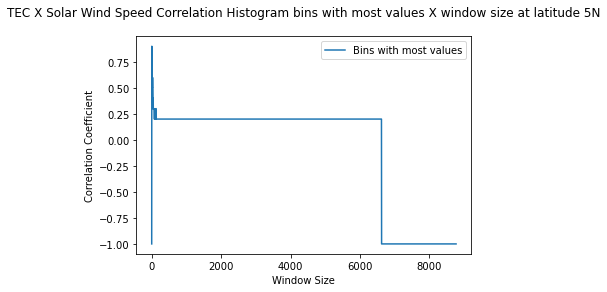

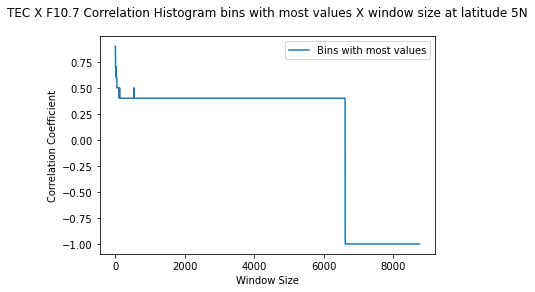

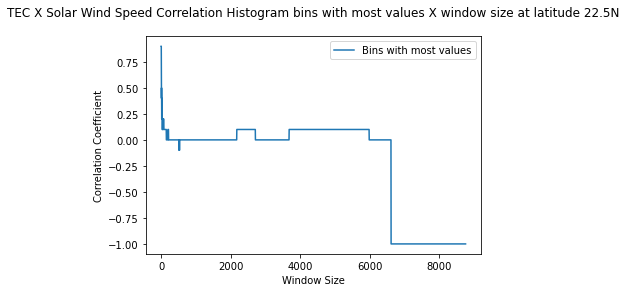

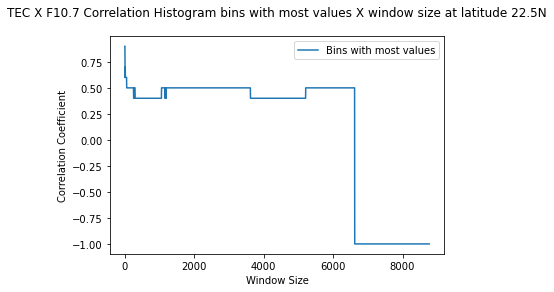

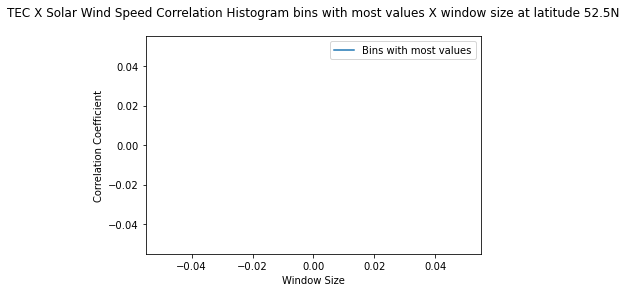

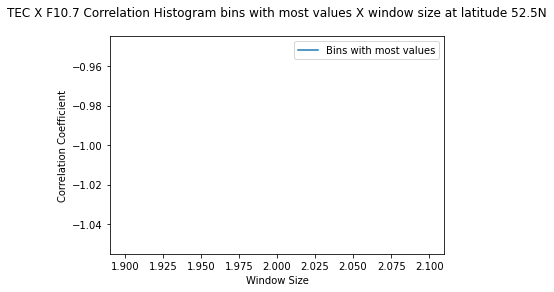

In [13]:
plotsavePath = "C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/"
win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws_lat_5.h5")
# print(win_most_bin[0:200])
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')
plttitle = 'TEC X Solar Wind Speed Correlation Histogram bins with most values X window size at latitude 5N'
plt.title(plttitle, pad=20)

plt.savefig(plotsavePath + plttitle + '.jpg',  
            bbox_inches='tight', dpi= 200)
plt.show()


win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10_lat_5.h5")
# print(win_most_bin)
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')
plttitle = 'TEC X F10.7 Correlation Histogram bins with most values X window size at latitude 5N'
plt.title(plttitle, pad=20)

plt.savefig(plotsavePath + plttitle + '.jpg',  
            bbox_inches='tight', dpi= 200)
plt.show()


win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws_lat_22_5.h5")
# print(win_most_bin)
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')

plttitle = 'TEC X Solar Wind Speed Correlation Histogram bins with most values X window size at latitude 22.5N'
plt.title(plttitle, pad=20)

plt.savefig(plotsavePath + plttitle + '.jpg',  
            bbox_inches='tight', dpi= 200)
plt.show()


win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10_lat_22_5.h5")
# print(win_most_bin)
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')

plttitle = 'TEC X F10.7 Correlation Histogram bins with most values X window size at latitude 22.5N'
plt.title(plttitle, pad=20)

plt.savefig(plotsavePath + plttitle + '.jpg',  
            bbox_inches='tight', dpi= 200)
plt.show()




win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws_lat_52_5.h5")
# print(win_most_bin)
win_most_bin = win_most_bin[50:120]
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')

plttitle = 'TEC X Solar Wind Speed Correlation Histogram bins with most values X window size at latitude 52.5N'
plt.title(plttitle, pad=20)

plt.savefig(plotsavePath + plttitle + '.jpg',  
            bbox_inches='tight', dpi= 200)
plt.show()


win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10_lat_52_5.h5")
# print(win_most_bin)
win_most_bin['bin_with_most_values'].plot()
plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Correlation Coefficient')
plt.title('TEC X F10.7 Correlation Histogram bins with most values X window size at latitude 52.5N', pad=20)

plttitle = 'TEC X F10.7 Correlation Histogram bins with most values X window size at latitude 52.5N'
plt.title(plttitle, pad=20)

plt.savefig(plotsavePath + plttitle + '.jpg',  
            bbox_inches='tight', dpi= 200)
plt.show()

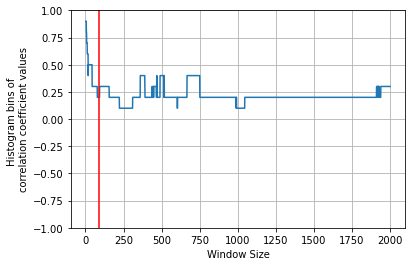

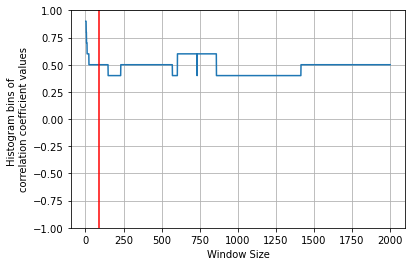

In [66]:
plotsavePath = "C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/"
win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws_lat_12_5.h5")
# print(win_most_bin[0:200])
win_most_bin = win_most_bin[:2000]
win_most_bin['bin_with_most_values'].plot()
# plt.legend(['Bins with most values'])

plt.xlabel('Window Size')
plt.ylabel('Histogram bins of \ncorrelation coefficient values')
plttitle = 'TEC X Solar Wind Speed Correlation Histogram bins with most values X window size at latitude 12.5N'
# plt.title(plttitle, pad=20)
plt.axvline(x=90, color='r')
plt.grid()
plt.ylim([-1, 1])


plt.savefig(final_plot_location + plttitle + '.pdf',  
            bbox_inches='tight', dpi= 300)
plt.show()


win_most_bin = readH5File("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10_lat_12_5.h5")
# print(win_most_bin)
win_most_bin = win_most_bin[:2000]

win_most_bin['bin_with_most_values'].plot()
# plt.legend(['Bins with most values'])
plt.xlabel('Window Size')
plt.ylabel('Histogram bins of \ncorrelation coefficient values')
plttitle = 'TEC X F10.7 Correlation Histogram bins with most values X window size at latitude 12.5N'
# plt.title(plttitle, pad=20)
plt.axvline(x=90, color='r')
plt.grid()
plt.ylim([-1, 1])


plt.savefig(final_plot_location + plttitle + '.pdf',  
            bbox_inches='tight', dpi= 300)
plt.show()


In [10]:
def extractDataByDate(data, startDate, endDate):
    data.index =  pd.to_datetime(data.index, format='%Y-%m-%d')
    extData = data[(data.index.get_level_values('date') >= startDate) & 
                   (data.index.get_level_values('date') <= endDate)]
    return extData

sDate = '1998-01-01'
eDate = '2020-12-31'


def extractDataByIndexDate(data, startDate, endDate):
    data.index =  pd.to_datetime(data.index, format='%Y-%m-%d')
    extData = data[(data.index.get_level_values(level=0) >= startDate) & 
                   (data.index.get_level_values(level=0) <= endDate)]
    return extData


def extractDataAtDate(data, date):
    extData = data[pd.to_datetime(data.index.get_level_values(level=0))==date]
    return extData

mean 0.3484652739694808


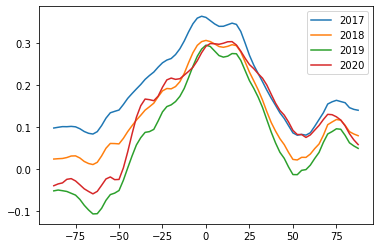

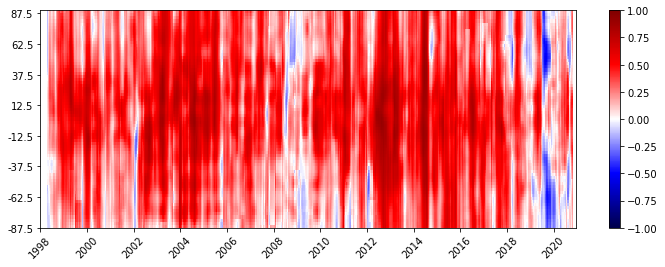

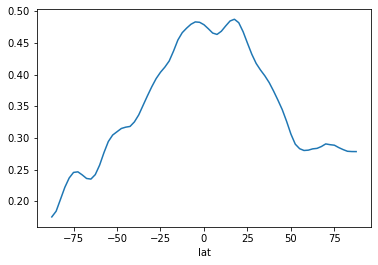

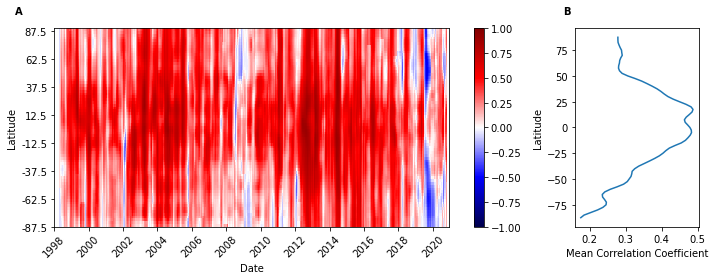

In [80]:
# tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"


tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
# print(tec_f10_7_corrr.max().max())
# print(tec_f10_7_corrr.min().min())
# tec_f10_7_corrr.min()[30:60].plot()
# plt.show()
# tec_f10_7_corrr.max()[-25:40].plot()
# plt.show()

tec_f10_7_corrr = extractDataByDate(tec_f10_7_corrr, sDate, eDate)

corr_mov_avg_date = pd.DataFrame()
for y in range(1998, 2021, 1):
    sy = y
    ey = y+4
    dateData = pd.DataFrame(tec_f10_7_corrr['{}-01-01'.format(sy):'{}-12-31'.format(ey)])
    latData = dateData.T.mean(axis=1).rename('{}'.format(sy))
#     print(latData)
    corr_mov_avg_date = corr_mov_avg_date.append(latData)
    
# print(corr_mov_avg_date.loc[['2006', '2018']].T[-12.5:12.5])
corr_mov_avg_date.loc['2017':].T.plot()    
# print(corr_mov_avg_date.T)    
    
tec_f10_7_corrr = tec_f10_7_corrr.T

print('mean', tec_f10_7_corrr.mean().mean())

# print(pd.to_datetime(tec_f10_7_corrr.columns, format='%Y-%m-%d').year)
plt.figure(figsize=(12, 4))
plt.pcolormesh(tec_f10_7_corrr, cmap='seismic')
cbar = plt.colorbar()
indexValues = tec_f10_7_corrr.index.values
tiks = range(0,71,10)
lbl = indexValues[tiks]
plt.yticks(ticks=tiks, labels=lbl)

plt.clim(-1,1)
dateColumn = pd.to_datetime(tec_f10_7_corrr.columns, format='%Y-%m-%d').year
xtiks = range(0,len(dateColumn),732)
xlbl = dateColumn[xtiks]
plt.xticks(ticks=xtiks, labels=xlbl, rotation=45)

# plt.savefig(plotsavePath + 'correlation_map_f10_tec' + '.jpg',  
#             bbox_inches='tight', dpi= 200)

plt.show()


mean = tec_f10_7_corrr.mean(axis=1)
(axs2) = mean.plot()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True, gridspec_kw={'width_ratios': [4, 1]})
img = ax1.pcolormesh(tec_f10_7_corrr, cmap='seismic', vmin=-1, vmax=1)
# cbar_ax = fig.add_axes([1, 0.155, 0.015, 0.8])
fig.colorbar(img, ax=ax1)

ax1.set_yticks(tiks) 
ax1.set_yticklabels(lbl)

ax1.set_xticks(xtiks) 
ax1.set_xticklabels(xlbl, rotation=45)
ax1.set_xlabel('Date')
ax1.set_ylabel('Latitude')

ax2.plot(mean.values, mean.index)
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Mean Correlation Coefficient')

ax1.text(-0.1, 1.07, 'A', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2.text(-0.1, 1.07, 'B', transform=ax2.transAxes, 
            size=10, weight='bold')
# ax2.set_yticks(tiks) 
# ax2.set_yticklabels(lbl)
fig.savefig(final_plot_location + 'correlation_map_f10_tec_mean' + '.pdf', bbox_inches='tight', dpi= 150)

-0.8110617219044322


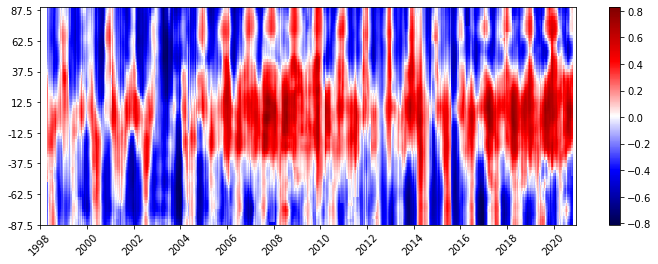

lat
-87.5   -0.170388
-85.0   -0.176038
-82.5   -0.186486
-80.0   -0.197749
-77.5   -0.201311
           ...   
 77.5   -0.143805
 80.0   -0.165466
 82.5   -0.189536
 85.0   -0.204278
 87.5   -0.212051
Length: 71, dtype: float64


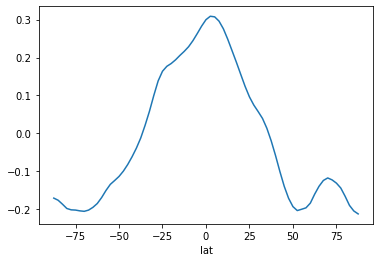

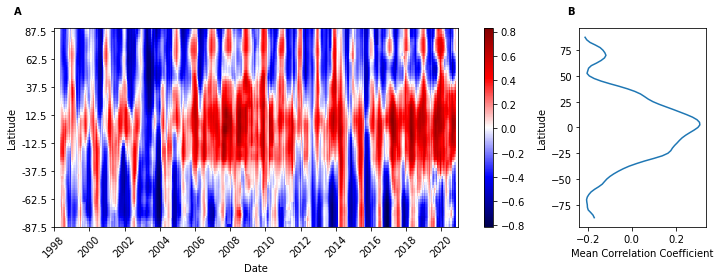

In [75]:
# tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_sws\\tec_sws.h5"
tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_sws\\tec_sws.h5"


tec_sws_corrr = readH5File(tec_sws_corrr_file)
tec_sws_corrr = extractDataByDate(tec_sws_corrr, sDate, eDate)

print(tec_sws_corrr.min().min())
tec_sws_corrr = tec_sws_corrr.T
# print(pd.to_datetime(tec_f10_7_corrr.columns, format='%Y-%m-%d').year)
plt.figure(figsize=(12, 4))
plt.pcolormesh(tec_sws_corrr, cmap='seismic')
cbar = plt.colorbar()
indexValues = tec_sws_corrr.index.values
tiks = range(0,71,10)
lbl = indexValues[tiks]
plt.yticks(ticks=tiks, labels=lbl)
# tec_f10_7_corrr.T.plot()

# plt.clim(-1,1)
dateColumn = pd.to_datetime(tec_sws_corrr.columns, format='%Y-%m-%d').year
xtiks = range(0,len(dateColumn),732)
xlbl = dateColumn[xtiks]
plt.xticks(ticks=xtiks, labels=xlbl, rotation=45)
# plt.savefig(plotsavePath + 'correlation_map_sws_tec' + '.jpg',  
#             bbox_inches='tight', dpi= 200)
plt.show()

mean = tec_sws_corrr.mean(axis=1)
(axs2) = mean.plot()

print(mean)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True, gridspec_kw={'width_ratios': [4, 1]})
img = ax1.pcolormesh(tec_sws_corrr, cmap='seismic')
# cbar_ax = fig.add_axes([1, 0.155, 0.015, 0.8])
fig.colorbar(img, ax=ax1)

ax1.set_yticks(tiks) 
ax1.set_yticklabels(lbl)

ax1.set_xticks(xtiks) 
ax1.set_xticklabels(xlbl, rotation=45)
ax1.set_xlabel('Date')
ax1.set_ylabel('Latitude')

ax2.plot(mean.values, mean.index)
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Mean Correlation Coefficient')
# ax2.set_yticks(tiks) 
# ax2.set_yticklabels(lbl)

ax1.text(-0.1, 1.07, 'A', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2.text(-0.1, 1.07, 'B', transform=ax2.transAxes, 
            size=10, weight='bold')
fig.savefig(final_plot_location + 'correlation_map_sws_tec_mean' + '.pdf', bbox_inches='tight', dpi= 150)

In [31]:
s_year = [2003, 2008, 2013]
lat = [60, 30 ,0]
param = ['f10', 'sws']
lon = 15
windowSize = 90

correlation_sws = pd.DataFrame()
correlation_f10 = pd.DataFrame()

tecPathprev = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(2003) + '.h5'
tecPrev = readH5File(tecPathprev)
# print(tecPrev[[60,30,0]].groupby(level = 'lat', axis = 1).mean())


for analysisYear in s_year:
    for par in param:

        spDate = ('{}-01-01'.format(analysisYear-1))
        epDate = ('{}-12-31'.format(analysisYear+1))
        # print(spDate)

        tecPathprev = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(analysisYear-1) + '.h5'
        tecPathnext = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(analysisYear+1) + '.h5'
        tecPath = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(analysisYear) + '.h5'

        tecPrev = readH5File(tecPathprev)
        tecNext = readH5File(tecPathnext)
        tecData = tecPrev
        tecData = tecData.append(readH5File(tecPath))
        tecData = tecData.append(tecNext)
        # tecData = readH5File(tecPath)
        tecData = tecData.interpolate()

        tecAtLat = tecData[[60, 30, 0]]
        tecAtLat = tecAtLat.groupby(level = 'lat', axis = 1).mean()
        tecAtLat = tecAtLat.unstack()


        if par == 'f10':
            f10_7_rel_diff_period = extractDataByIndexDate(f10_7_rel_diff, spDate, epDate)
            correlation_tec_f10_period = tecAtLat.rolling(windowSize).corr(f10_7_rel_diff_period['f10_7'])
            correlation_tec_f10_period = extractDataByIndexDate(correlation_tec_f10_period, '{}-01-01'.format(analysisYear), '{}-12-31'.format(analysisYear))
#                 print(correlation_tec_f10_period)
            correlation_f10 = correlation_f10.append(correlation_tec_f10_period)

#                 correlation_tec_f10_period = correlation_tec_f10_period.T


#                 plt.figure(figsize=(6, 4))
#                 plt.pcolormesh(correlation_tec_f10_period, cmap='seismic')
#                 cbar = plt.colorbar()
#                 plt.clim(-1,1)
#                 plt.show()



        if par == 'sws':
            swsDataPeriod = extractDataByIndexDate(swsData, spDate, epDate)
            correlation_tec_sws_period = tecAtLat.rolling(windowSize).corr(swsDataPeriod['sws'])
            correlation_tec_sws_period = extractDataByIndexDate(correlation_tec_sws_period, '{}-01-01'.format(analysisYear), '{}-12-31'.format(analysisYear))
            correlation_sws = correlation_sws.append(correlation_tec_sws_period)
#                 correlation_tec_sws_period = correlation_tec_sws_period.T

#                 plt.figure(figsize=(6, 4))
#                 plt.pcolormesh(correlation_tec_sws_period, cmap='seismic')
#                 cbar = plt.colorbar()
#                 plt.clim(-1,1)
#                 plt.show()


        print(par, analysisYear)
            
            

            




            


f10 2003
sws 2003
f10 2008
sws 2008
f10 2013
sws 2013


In [32]:
print(correlation_sws)
print(correlation_f10)


correlation_f10.to_hdf('correlation_tec_f10_03_08_13_ut.h5', key='df')
correlation_sws.to_hdf('correlation_tec_sws_03_08_13_ut.h5', key='df')

lat             0.0                                                     \
ut          00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00   
date                                                                     
2003-01-01  0.249784  0.250558  0.274783  0.273517  0.270144  0.281689   
2003-01-02  0.280271  0.282639  0.305741  0.303867  0.301611  0.312586   
2003-01-03  0.285112  0.288773  0.311095  0.307899  0.304237  0.313410   
2003-01-04  0.285517  0.287858  0.308043  0.304479  0.299996  0.310272   
2003-01-05  0.296183  0.299878  0.318893  0.314277  0.308767  0.318010   
...              ...       ...       ...       ...       ...       ...   
2013-12-27  0.372661  0.368750  0.376908  0.388823  0.400605  0.468280   
2013-12-28  0.375691  0.378358  0.394918  0.410486  0.418588  0.480515   
2013-12-29  0.376511  0.384363  0.401747  0.425766  0.437257  0.498198   
2013-12-30  0.380791  0.387088  0.403589  0.431711  0.443041  0.501952   
2013-12-31  0.383513  0.385729  0.3944

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level1] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->block0_items_level1] [items->None]

  f = lambda store: store.put(


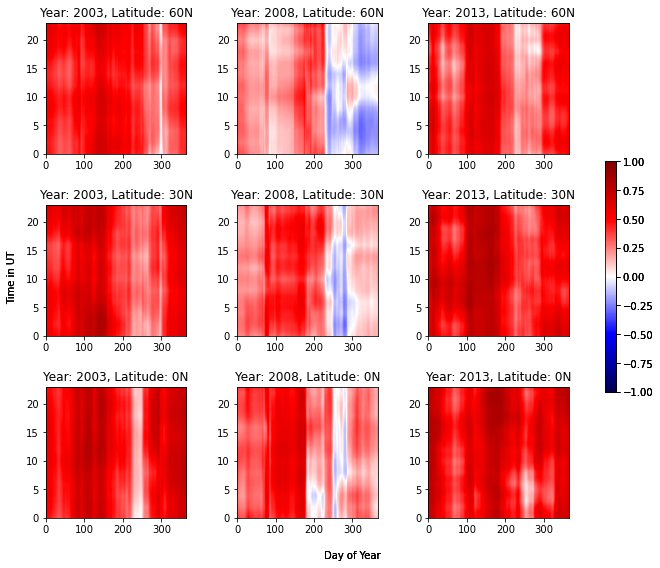

In [14]:
corr_f10_ut = readH5File('correlation_tec_f10_03_08_13_ut.h5')

s_year = [2003, 2008, 2013]
lat = [60, 30 ,0]


fig, axs = plt.subplots(len(s_year), len(lat))
fig.set_figheight(8)
fig.set_figwidth(10)
fig.tight_layout(pad=3.0)


for j in np.arange(len(lat)):
    plotlat = lat[j]
    for i in np.arange(len(s_year)):
        plotyear = s_year[i]
    
        data_year = extractDataByIndexDate(corr_f10_ut, '{}-01-01'.format(plotyear), '{}-12-31'.format(plotyear))
        data_year_lat = data_year[(plotlat)]
        data_ut = data_year_lat.T
    
        
        
        img = axs[j, i].imshow(data_ut, interpolation='gaussian', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
        axs[j, i].set_title('Year: {}, Latitude: {}N'.format(plotyear, plotlat))
        axs[j, i].set_ylim(ymin=0, ymax=23)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.3, 0.015, 0.4])
    fig.colorbar(img, cax=cbar_ax)
    
    fig.text(0.5, 0.01, 'Day of Year', ha='center')
    fig.text(0.02, 0.5, 'Time in UT', va='center', rotation='vertical')
    
plt.savefig('correlation_tec_f10_03_08_13_ut.jpg', bbox_inches = 'tight')

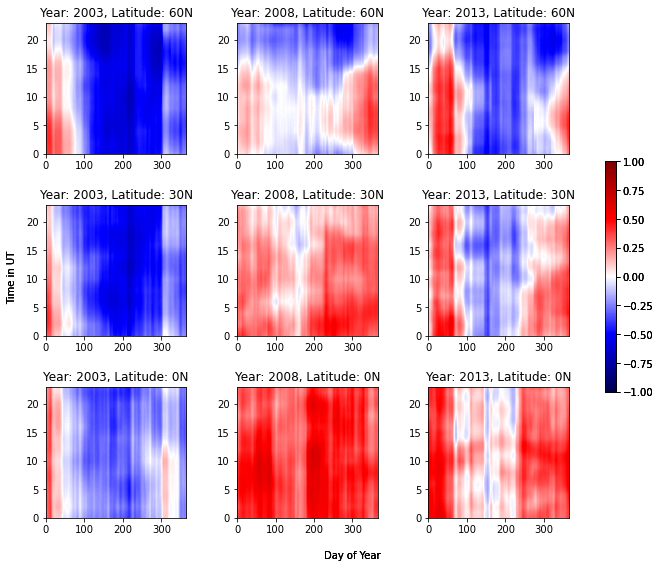

In [28]:
corr_f10_ut = readH5File('correlation_tec_sws_03_08_13_ut.h5')

s_year = [2003, 2008, 2013]
lat = [60, 30 ,0]


fig, axs = plt.subplots(len(s_year), len(lat))
fig.set_figheight(8)
fig.set_figwidth(10)
fig.tight_layout(pad=3.0)


for j in np.arange(len(lat)):
    plotlat = lat[j]
    for i in np.arange(len(s_year)):
        plotyear = s_year[i]
    
        data_year = extractDataByIndexDate(corr_f10_ut, '{}-01-01'.format(plotyear), '{}-12-31'.format(plotyear))
        data_year_lat = data_year[(plotlat)]
        data_ut = data_year_lat.T
    
        
        
        img = axs[j, i].imshow(data_ut, interpolation='gaussian', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
        axs[j, i].set_title('Year: {}, Latitude: {}N'.format(plotyear, plotlat))
        axs[j, i].set_ylim(ymin=0, ymax=23)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.3, 0.015, 0.4])
    fig.colorbar(img, cax=cbar_ax)
    
    fig.text(0.5, 0.01, 'Day of Year', ha='center')
    fig.text(0.02, 0.5, 'Time in UT', va='center', rotation='vertical')
    
plt.savefig('correlation_tec_sws_03_08_13_ut.jpg', bbox_inches = 'tight')

In [22]:
s_year = [2003, 2008, 2013]
lat = [60, 30 ,0]
param = ['f10', 'sws']
lon = 15
windowSize = 90

correlation_sws = pd.DataFrame()
correlation_f10 = pd.DataFrame()

tecPathprev = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(2003) + '.h5'
tecPrev = readH5File(tecPathprev)
# print(tecPrev[[60,30,0]].groupby(level = 'lat', axis = 1).mean())


for analysisYear in s_year:
    for par in param:

        spDate = ('{}-01-01'.format(analysisYear-1))
        epDate = ('{}-12-31'.format(analysisYear+1))
        # print(spDate)

        tecPathprev = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(analysisYear-1) + '.h5'
        tecPathnext = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(analysisYear+1) + '.h5'
        tecPath = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(analysisYear) + '.h5'

        tecPrev = readH5File(tecPathprev)
#         print(tecPrev[[(60,15), (30, 15), (0, 15)]])
        tecNext = readH5File(tecPathnext)
        tecData = tecPrev
        tecData = tecData.append(readH5File(tecPath))
        tecData = tecData.append(tecNext)
        # tecData = readH5File(tecPath)
        tecData = tecData.interpolate()
        
        

        tecAtLat = tecData[[(60,15), (30, 15), (0, 15)]]
        tecAtLat = tecAtLat.groupby(level = 'lat', axis = 1).mean()
        tecAtLat = tecAtLat.unstack()


        if par == 'f10':
            f10_7_rel_diff_period = extractDataByIndexDate(f10_7_rel_diff, spDate, epDate)
            correlation_tec_f10_period = tecAtLat.rolling(windowSize).corr(f10_7_rel_diff_period['f10_7'])
            correlation_tec_f10_period = extractDataByIndexDate(correlation_tec_f10_period, '{}-01-01'.format(analysisYear), '{}-12-31'.format(analysisYear))
#                 print(correlation_tec_f10_period)
            correlation_f10 = correlation_f10.append(correlation_tec_f10_period)

#                 correlation_tec_f10_period = correlation_tec_f10_period.T


#                 plt.figure(figsize=(6, 4))
#                 plt.pcolormesh(correlation_tec_f10_period, cmap='seismic')
#                 cbar = plt.colorbar()
#                 plt.clim(-1,1)
#                 plt.show()



        if par == 'sws':
            swsDataPeriod = extractDataByIndexDate(swsData, spDate, epDate)
            correlation_tec_sws_period = tecAtLat.rolling(windowSize).corr(swsDataPeriod['sws'])
            correlation_tec_sws_period = extractDataByIndexDate(correlation_tec_sws_period, '{}-01-01'.format(analysisYear), '{}-12-31'.format(analysisYear))
            correlation_sws = correlation_sws.append(correlation_tec_sws_period)
#                 correlation_tec_sws_period = correlation_tec_sws_period.T

#                 plt.figure(figsize=(6, 4))
#                 plt.pcolormesh(correlation_tec_sws_period, cmap='seismic')
#                 cbar = plt.colorbar()
#                 plt.clim(-1,1)
#                 plt.show()


        print(par, analysisYear)
            
            
correlation_f10.to_hdf('correlation_tec_f10_03_08_13_ut_lat_lon.h5', key='df')
correlation_sws.to_hdf('correlation_tec_sws_03_08_13_ut_lat_lon.h5', key='df')
            




            


f10 2003
sws 2003
f10 2008
sws 2008
f10 2013
sws 2013


C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level1] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->block0_items_level1] [items->None]

  f = lambda store: store.put(


date      2003-01-01  2003-01-02  2003-01-03  2003-01-04  2003-01-05  \
ut                                                                     
00:00:00    0.247528    0.248973    0.247888    0.244134    0.245065   
01:00:00    0.234335    0.236514    0.235289    0.232037    0.233010   
02:00:00    0.217190    0.221517    0.220769    0.217906    0.219008   
03:00:00    0.200196    0.208889    0.209890    0.207267    0.208489   
04:00:00    0.174274    0.183885    0.185537    0.182607    0.183912   
05:00:00    0.144965    0.153105    0.156182    0.153709    0.155239   
06:00:00    0.149399    0.156646    0.161167    0.159622    0.161094   
07:00:00    0.311240    0.314937    0.317122    0.317305    0.318271   
08:00:00    0.501411    0.502653    0.503985    0.506406    0.507873   
09:00:00    0.516196    0.519890    0.519827    0.522644    0.523488   
10:00:00    0.527078    0.532278    0.529868    0.533304    0.534789   
11:00:00    0.503382    0.509132    0.506125    0.510169    0.51

[24 rows x 365 columns]


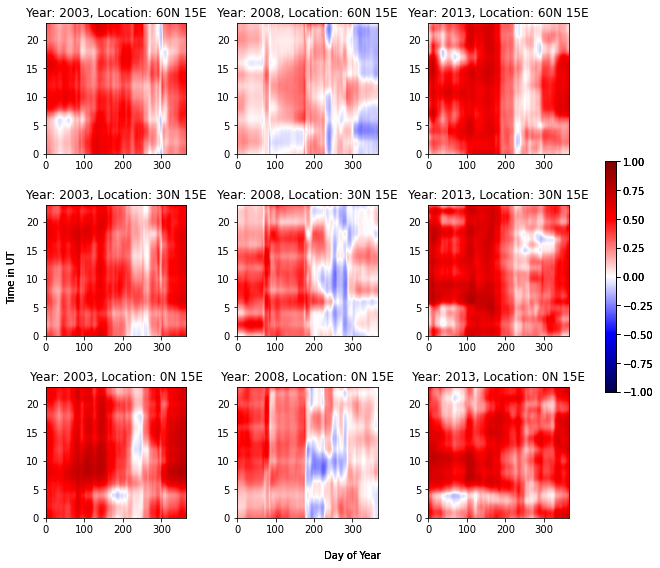

In [29]:
corr_f10_ut = readH5File('correlation_tec_f10_03_08_13_ut_lat_lon.h5')

s_year = [2003, 2008, 2013]
lat = [60, 30 ,0]


fig, axs = plt.subplots(len(s_year), len(lat))
fig.set_figheight(8)
fig.set_figwidth(10)
fig.tight_layout(pad=3.0)


for j in np.arange(len(lat)):
    plotlat = lat[j]
    for i in np.arange(len(s_year)):
        plotyear = s_year[i]
    
        data_year = extractDataByIndexDate(corr_f10_ut, '{}-01-01'.format(plotyear), '{}-12-31'.format(plotyear))
        data_year_lat = data_year[(plotlat)]
        data_ut = data_year_lat.T
    
        
        img = axs[j, i].imshow(data_ut, interpolation='gaussian', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
        axs[j, i].set_title('Year: {}, Location: {}N 15E'.format(plotyear, plotlat))
        axs[j, i].set_ylim(ymin=0, ymax=23)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.3, 0.015, 0.4])
    fig.colorbar(img, cax=cbar_ax)
    
    fig.text(0.5, 0.01, 'Day of Year', ha='center')
    fig.text(0.02, 0.5, 'Time in UT', va='center', rotation='vertical')
    
plt.savefig('correlation_tec_f10_03_08_13_ut_lat_lon.jpg', bbox_inches = 'tight')

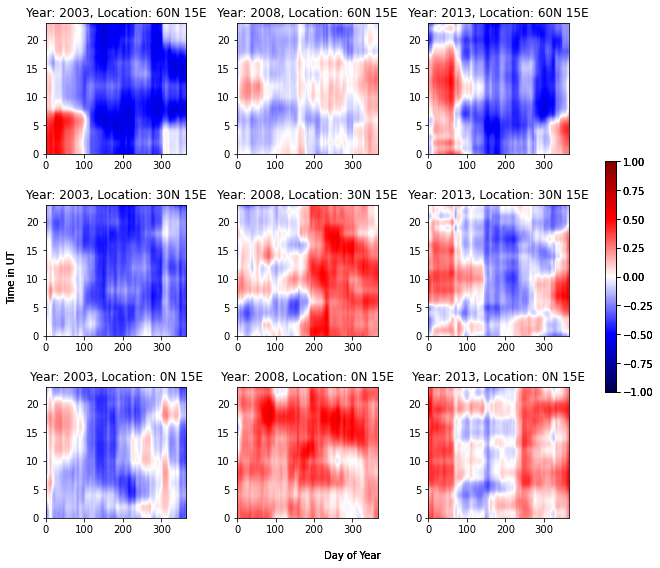

In [27]:
corr_f10_ut = readH5File('correlation_tec_sws_03_08_13_ut_lat_lon.h5')

s_year = [2003, 2008, 2013]
lat = [60, 30 ,0]


fig, axs = plt.subplots(len(s_year), len(lat))
fig.set_figheight(8)
fig.set_figwidth(10)
fig.tight_layout(pad=3.0)


for j in np.arange(len(lat)):
    plotlat = lat[j]
    for i in np.arange(len(s_year)):
        plotyear = s_year[i]
    
        data_year = extractDataByIndexDate(corr_f10_ut, '{}-01-01'.format(plotyear), '{}-12-31'.format(plotyear))
        data_year_lat = data_year[(plotlat)]
        data_ut = data_year_lat.T
    
        
        
        img = axs[j, i].imshow(data_ut, interpolation='gaussian', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
        axs[j, i].set_title('Year: {}, Location: {}N 15E'.format(plotyear, plotlat))
        axs[j, i].set_ylim(ymin=0, ymax=23)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.3, 0.015, 0.4])
    fig.colorbar(img, cax=cbar_ax)
    
    fig.text(0.5, 0.01, 'Day of Year', ha='center')
    fig.text(0.02, 0.5, 'Time in UT', va='center', rotation='vertical')
    
plt.savefig('correlation_tec_sws_03_08_13_ut_lat_lon.jpg', bbox_inches = 'tight')

In [54]:
tecPath = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/' + str(2003) + '.h5'
tecData = readH5File(tecPath)
# print(tecData)
# tecData.index =  pd.to_datetime(tecData.index.get_level_values(level=0), format='%Y-%m-%d')
# print(tecData.index.get_level_values(level=0)=='2003-01-01')
tecData = tecData.interpolate()
tecData = tecData[pd.to_datetime(tecData.index.get_level_values(level=0))=='2003-07-20']
# print(tecData[pd.to_datetime(tecData.index.get_level_values(level=0))=='2003-07-20'])
tecData = tecData.interpolate()
# tecData = tecData.unstack()

print(tecData)

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2003-07-20 00:00:00  -7.704444  -7.994758  -7.698327  -7.259955  -7.954547   
           01:00:00  -0.527222  -0.685706  -0.723384  -0.814129  -1.266506   
           02:00:00   6.650001   6.623345   6.251558   5.631696   5.421535   
           03:00:00  -0.551906  -1.091222  -1.353990  -1.890887  -2.072366   
           04:00:00  -7.753813  -8.805790  -8.959538  -9.413471  -9.566268   
           05:00:00 -10.041289 -10.909745 -11.063715 -11.213586 -11.323058   
           06:00:00 -12.328765 -13.013700 -13.167892 -13.013701 -13.079849   
           07:00:00  -7.897862  -8.774055  -8.992449  -9.493724  -9.627334   
           08:00:00  -3.466958  -4.534410  -4.817005  -5.973748  -6.174820   
           09:00:00  -8.266884  -9.392907  -9.807072 -10.955211 

lat                 60.0 30.0  0.0 
lon                   15   15    15
date       ut                      
1997-01-01 00:00:00  NaN  NaN   NaN
           01:00:00  NaN  NaN   NaN
           02:00:00  NaN  NaN   NaN
           03:00:00  NaN  NaN   NaN
           04:00:00  NaN  NaN   NaN
...                  ...  ...   ...
2020-12-31 19:00:00  1.7  6.2  14.7
           20:00:00  2.2  6.4  13.4
           21:00:00  3.0  4.9  11.8
           22:00:00  2.4  6.0   9.0
           23:00:00  3.6  6.5   9.0

[210384 rows x 3 columns]
lat            60.0       30.0       0.0 
lon              15         15         15
ut                                       
00:00:00   5.832666  12.179635  16.419904
01:00:00   5.652296  11.254958  13.575378
02:00:00   5.695904  10.331265  11.679680
03:00:00   6.073588   9.481842  10.003207
04:00:00   6.728535   9.365833   8.982142
05:00:00   7.665006  11.533818  11.185954
06:00:00   9.048479  15.464042  17.588402
07:00:00  10.897792  19.223496  23.854370
08:00:0

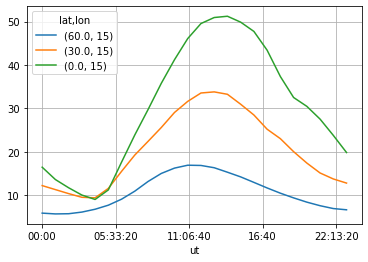

lat            60.0                                                        \
lon              15                                                         
ut         00:00:00 01:00:00 02:00:00 03:00:00 04:00:00 05:00:00 06:00:00   
date                                                                        
1997-01-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-02      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-03      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-04      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-05      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...             ...      ...      ...      ...      ...      ...      ...   
2020-12-27      2.6      2.3      3.0      2.7      2.2      2.6      2.8   
2020-12-28      3.1      3.0      3.7      3.3      2.8      3.1      3.2   
2020-12-29      3.1      2.5      3.0      2.9      2.4      2.6      3.1   

C:\Users\davi_fr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->block0_items_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level2] [items-

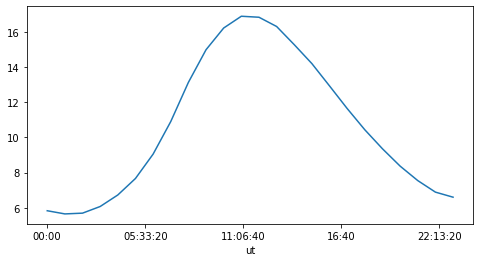

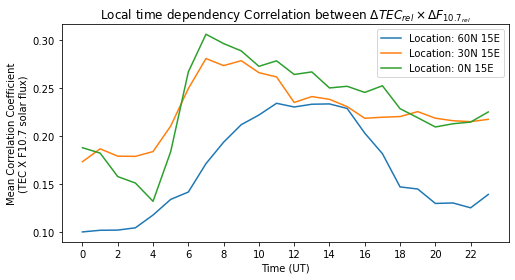

C:\Users\davi_fr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


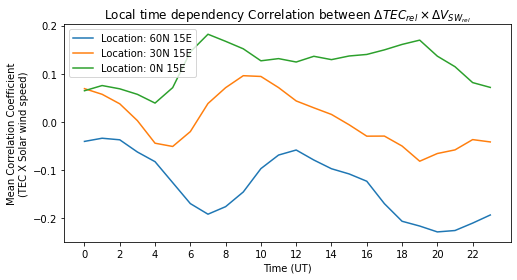

In [410]:
from scipy.signal import savgol_filter
location = [(60, 15), (30, 15), (0, 15)]
# location = [60, 30, 0]
param = ['f10', 'sws']

windowSize = 60
# tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
# sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
# f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"


tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\append\\tec\\tec.h5"
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"

f10_7_rel_diff = readH5File(f10_7_rel_diff_file)
f10_7_rel_diff.index = pd.to_datetime(f10_7_rel_diff.index)
# print(f10_7_rel_diff.dtypes)
swsData = readH5File(sws_rel_diff)
swsData.index = pd.to_datetime(swsData.index)
tecDataFull = pd.DataFrame()


for year in analysisPeriod:
    tecPath = 'C:/Users/davi_fr/Documents/Thesis Project Final/correlation_analysis_01122022/computations/relative_difference/tec/' + str(year) + '.h5'
    tecPath = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\" + str(year) + '.h5'
    tecData = readH5File(tecPath)[location]
#     tecData = tecData.groupby(level = 'lat', axis =1).mean()
    tecDataFull = tecDataFull.append(tecData)
#     print(tecData)
    
    
tecDataFull = tecDataFull.interpolate()


# tecDataFull = tecDataFull.rolling(2, min_periods = 1).mean().shift(-1)
print(tecDataFull)
print(tecDataFull.groupby(level='ut', axis=0).mean())
tecDataFull.groupby(level='ut', axis=0).mean().plot()
plt.grid()
plt.show()

tecDataFull = tecDataFull.unstack()
tecDataFull.to_csv('time.csv')
print(tecDataFull)
tecDataFullMa_27 = tecDataFull.rolling(27, min_periods=12).mean().shift(int(27/2)*-1)
tecDataFullRelDiff = ((tecDataFull - tecDataFullMa_27)/tecDataFullMa_27)*100
# print(tecDataFullRelDiff)

# tecDataFullRelDiff[(60, 15)].plot(figsize=(8,3))



# tecDataFull = tecDataFullRelDiff


# tecDataFull = tecDataFull.unstack()
print(tecDataFull[[tecDataFull.columns[0]]])



figuresize = (8,4)

# tecDataFull = tecDataFull.unstack()
tecDataFull.index = pd.to_datetime(tecDataFull.index)

tecDataFull[location[0]].mean().plot(figsize=figuresize)
# print(tecDataFull)    

min_period = 27
for par in param:
    if par == 'f10':
        correlation_tec_f10_period = tecDataFull.rolling(windowSize, min_periods = min_period).corr(f10_7_rel_diff['f10_7']).shift(int(windowSize/2)*-1)
        correlation_tec_f10_period = extractDataByIndexDate(correlation_tec_f10_period, '1998-01-01', '2020-12-31')
        correlation_tec_f10_period.to_hdf('correlation_tec_f10_loc_60_30_0_15_ut.h5', key='df')
        


    if par == 'sws':
        
        correlation_tec_sws_period = tecDataFull.rolling(windowSize, min_periods = min_period).corr(swsData['sws']).shift(int(windowSize/2)*-1)
        correlation_tec_sws_period = extractDataByIndexDate(correlation_tec_sws_period, '1998-01-01', '2020-12-31')
        correlation_tec_sws_period.to_hdf('correlation_tec_sws_loc_60_30_0_15_ut.h5', key='df')
        

    
            

        
        
sdate = '1998-01-01'
edate = '2020-12-31'
        
feature = 'rel_diff'        
        
        
corr_f10_ut = readH5File('correlation_tec_f10_loc_60_30_0_15_ut.h5')[sdate:edate]


meanCorrUt = pd.DataFrame()


for j in np.arange(len(location)):
    loc = location[j]
    dataAtLoc = corr_f10_ut[loc].T

    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)


    
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = figuresize, 
                ylabel = 'Mean Correlation Coefficient\n(TEC X F10.7 solar flux)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
x = np.arange(0,24, 1)
ax.set_xticks(meanCorrUt.index[::2])
ax.set_xticklabels(x[::2])
ax.set_title(r'Local time dependency Correlation between $\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
# ax.set_ylim([-0.6, 0.6])
plt.savefig(final_plot_location + 'mean_correlation_tec_f10_ut_lat_lon_15E'+feature+'.pdf', bbox_inches = 'tight')

plt.show()









# location = [(60, 15), (30, 15), (0, 15)]
corr_f10_ut = readH5File('correlation_tec_sws_loc_60_30_0_15_ut.h5')[sdate:edate]


meanCorrUt = pd.DataFrame()
for j in np.arange(len(location)):
    loc = location[j]
    dataAtLoc = corr_f10_ut[loc].T

    
    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)
        
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = figuresize, 
                ylabel = 'Mean Correlation Coefficient\n(TEC X Solar wind speed)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
ax.set_title(r'Local time dependency Correlation between $\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
x = np.arange(0,24, 1)
ax.set_xticks(meanCorrUt.index[::2])
ax.set_xticklabels(x[::2])
# ax.set_ylim([-0.6, 0.6])
# ax.set_ylim([-0.6, 0.6])

plt.savefig(final_plot_location + 'mean_correlation_tec_sws_ut_lat_lon_15E'+feature+'.pdf', bbox_inches = 'tight')
plt.show()

C:\Users\davi_fr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


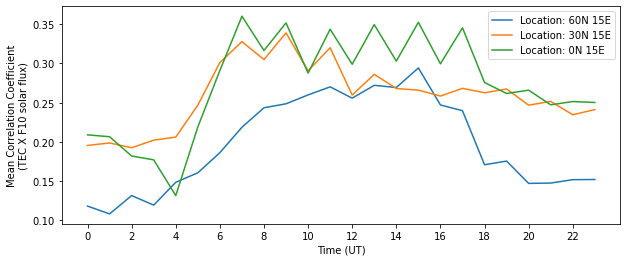

In [324]:
corr_f10_ut = readH5File('correlation_tec_f10_loc_60_30_0_15_ut.h5')


# s_year = [2003, 2008, 2013]
# lat = [60, 30 ,0]

meanCorrUt = pd.DataFrame()
# fig, axs = plt.subplots(len(location))
# fig.set_figheight(8)
# fig.set_figwidth(10)
# fig.tight_layout(pad=3.0)


for j in np.arange(len(location)):
    loc = location[j]
    dataAtLoc = corr_f10_ut[loc].T
    
#     dataAtLoc.T.mean().plot()
#     print(dataAtLoc.T.max())
    
#     plt.show()

    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)

    
        
        
#     img = axs[j].imshow(dataAtLoc, interpolation='gaussian', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
#     ticks = np.arange(0, len(dataAtLoc.columns.year), 732)
#     tickLabels = dataAtLoc.columns.year[ticks]
#     axs[j].set_xticks(ticks)
#     axs[j].set_xticklabels(tickLabels)
#     axs[j].set_title('Location: {}N {}E'.format(loc[0], loc[1]))
#     axs[j].set_ylim(ymin=0, ymax=23)
    
#     plt.show()
        
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.3, 0.015, 0.4])
# fig.colorbar(img, cax=cbar_ax)

# fig.text(0.5, 0.04, 'Date', ha='center')
# fig.text(0.03, 0.5, 'Time in UT', va='center', rotation='vertical')
    
# plt.savefig('correlation_tec_f10_ut_lat_lon_15E.jpg', bbox_inches = 'tight')


# plt.show()
# print(meanCorrUt)
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = (10,4), 
                ylabel = 'Mean Correlation Coefficient\n(TEC X F10 solar flux)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
x = np.arange(0,24, 1)
ax.set_xticks(meanCorrUt.index[::2])
ax.set_xticklabels(x[::2])
# ax.set_xticklabels(meanCorrUt.index[::2])
plt.savefig(final_plot_location + 'mean_correlation_tec_f10_ut_lat_lon_15E.pdf', bbox_inches = 'tight')

C:\Users\davi_fr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


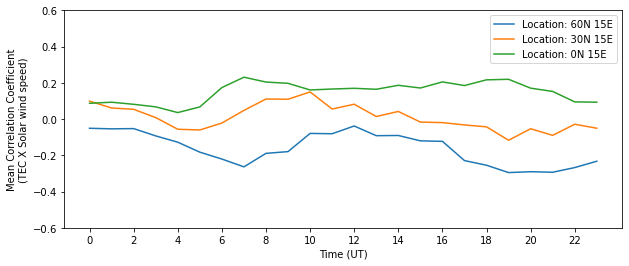

In [325]:
location = [(60, 15), (30, 15), (0, 15)]
corr_f10_ut = readH5File('correlation_tec_sws_loc_60_30_0_15_ut.h5')


meanCorrUt = pd.DataFrame()

# fig, axs = plt.subplots(len(location))
# fig.set_figheight(8)
# fig.set_figwidth(10)
# fig.tight_layout(pad=3.0)


for j in np.arange(len(location)):
    loc = location[j]
    dataAtLoc = corr_f10_ut[loc].T

    
    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)
        
#     img = axs[j].imshow(dataAtLoc, interpolation='gaussian', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
#     ticks = np.arange(0, len(dataAtLoc.columns.year), 732)
#     tickLabels = dataAtLoc.columns.year[ticks]
#     axs[j].set_xticks(ticks)
#     axs[j].set_xticklabels(tickLabels)
#     axs[j].set_title('Location: {}N {}E'.format(loc[0], loc[1]))
#     axs[j].set_ylim(ymin=0, ymax=23)
        
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.3, 0.015, 0.4])
# fig.colorbar(img, cax=cbar_ax)

# fig.text(0.5, 0.04, 'Date', ha='center')
# fig.text(0.03, 0.5, 'Time in UT', va='center', rotation='vertical')
    
# plt.savefig('correlation_tec_sws_ut_lat_lon_15E.jpg', bbox_inches = 'tight')

# plt.show()
# print(meanCorrUt)
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = (10,4), 
                ylabel = 'Mean Correlation Coefficient\n(TEC X Solar wind speed)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
x = np.arange(0,24, 1)
ax.set_xticks(meanCorrUt.index[::2])
ax.set_xticklabels(x[::2])
ax.set_ylim([-0.6, 0.6])

# ax.set_xticklabels(meanCorrUt.index[::2])
plt.savefig(final_plot_location + 'mean_correlation_tec_sws_ut_lat_lon_15E.pdf', bbox_inches = 'tight')

In [81]:
f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_23112022\\computations\\relative_difference\\f10_7\\f10_7.h5"
f10_7_rel_diff = readH5File(f10_7_rel_diff_file)
display(f10_7_rel_diff)
# print(f10_7_rel_diff.to_string())


,f10_7
date,
1997-01-01,NaN
1997-01-02,NaN
1997-01-03,NaN
1997-01-04,NaN
1997-01-05,NaN
...,...
2020-12-27,NaN
2020-12-28,NaN
2020-12-29,NaN


In [82]:
tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\append\\tec\\tec.h5"
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"



f10_7_rel_diff = readH5File(f10_7_rel_diff_file)
tecData = readH5File(tec_rel_diff)[[12.5]]
print(tecData)
# print(tecData[[5,22.5, 52.5]])
swsData = readH5File(sws_rel_diff)
binValue = np.arange(-1,1.1,0.1)
correlation_window_bin_with_most_values = pd.DataFrame(columns=['window_size', 'bin_with_most_values', 'actual_bin'])
correlation_window_bin_with_most_values_f10 = pd.DataFrame(columns=['window_size', 'bin_with_most_values', 'actual_bin'])

correlation

for windowSize in np.arange(2, len(tecData)):
# for windowSize in np.arange(2, 3):
    
    correlation_tec_sws = tecData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1).mean()
    correlation_tec_f10 = tecData.rolling(windowSize).corr(f10_7_rel_diff['f10_7']).shift(int(windowSize/2)*-1).mean()
#     print(correlation_tec_sws)
    
    
    hist, bins = np.histogram(correlation_tec_sws, bins=binValue)
    hist_f10, bins_f10 = np.histogram(correlation_tec_f10, bins=binValue)
#     print(correlation_tec_sws)
#     hist, bins = plt.hist(correlation_tec_sws, bins=binValue)
    
#     print(hist, bins)
    
    bin_with_most_value = binValue[list(hist).index(hist.max())].round(1)
    actualBin = bins[list(hist).index(hist.max())]
    row = {'window_size': windowSize, 
           'bin_with_most_values': bin_with_most_value,
           'actual_bin': actualBin
          }
    correlation_window_bin_with_most_values = correlation_window_bin_with_most_values.append(row, ignore_index=True)
    
    
    bin_with_most_value_f10 = binValue[list(hist_f10).index(hist_f10.max())].round(1)
    actualBin_f10 = bins_f10[list(hist_f10).index(hist_f10.max())]
    row_f10 = {'window_size': windowSize, 
           'bin_with_most_values': bin_with_most_value_f10,
           'actual_bin': actualBin_f10
          }
    correlation_window_bin_with_most_values_f10 = correlation_window_bin_with_most_values_f10.append(row_f10, ignore_index=True)
    

    print(row)
    
    
# print(len(tecData))
correlation_window_bin_with_most_values= correlation_window_bin_with_most_values.set_index('window_size')
correlation_window_bin_with_most_values_f10= correlation_window_bin_with_most_values_f10.set_index('window_size')

print(correlation_window_bin_with_most_values)
correlation_window_bin_with_most_values.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_sws_lat_12_5.h5", key= 'df')
correlation_window_bin_with_most_values_f10.to_hdf("C:/Users/davi_fr/Documents/Thesis Project Final/source_code/mean_correlation_window_all_latitude/correlation_window_bin_with_most_values_f10_lat_12_5.h5", key= 'df')


lat         12.5
date            
1997-01-01   NaN
1997-01-02   NaN
1997-01-03   NaN
1997-01-04   NaN
1997-01-05   NaN
...          ...
2020-12-27   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
2020-12-31   NaN

[8766 rows x 1 columns]


NameError: name 'correlation' is not defined

In [247]:
loc = (12.5, 0)
print(r'Mean absolute correlation of $\Delta TEC_{rel}$ at ')

Mean absolute correlation of $\Delta TEC_{rel}$ at 


lat              12.5
lon                 0
date                 
1997-01-01        NaN
1997-01-02        NaN
1997-01-03        NaN
1997-01-04        NaN
1997-01-05        NaN
...               ...
2020-12-27  14.300000
2020-12-28  17.341667
2020-12-29  16.579167
2020-12-30  18.433334
2020-12-31  15.383333

[8766 rows x 1 columns]


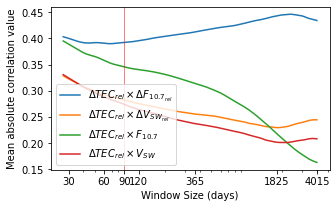

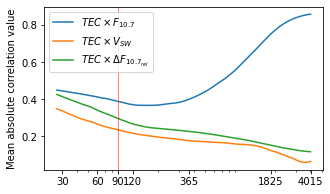

In [264]:
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"
tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\tec\\"

f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
tec = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\"

tecRelDiffData = pd.DataFrame()
tecData = pd.DataFrame()
loc = (12.5,0)
for year in analysisPeriod:
    tec_rel_diff_path = tec_rel_diff + '{}.h5'.format(year)
    temptecRelDiffData = readH5File(tec_rel_diff_path)[[loc]].interpolate()
    tecRelDiffData = tecRelDiffData.append(temptecRelDiffData)


    tec_path = tec + '{}.h5'.format(year)
    temptecData = readH5File(tec_path)[[loc]].interpolate()
    tecData = tecData.append(temptecData)



tecRelDiffData = tecRelDiffData.groupby(level = ['date'], axis = 0).mean()
tecData = tecData.groupby(level = ['date'], axis = 0).mean()
print(tecData)







F10Data = readH5File(f10).interpolate()
F10RelDiffData = readH5File(f10_7_rel_diff).interpolate()
swsData = readH5File(sws).interpolate()
swsRelDiffData = readH5File(sws_rel_diff).interpolate()












meanCorrelation = pd.DataFrame(columns=['window_size', 'relTEC_relSWS', 'relTEC_relF10', 'relTEC_SWS', 'relTEC_F10', 'tec_f10', 'tec_relF10', 'tec_sws'])

for windowSize in np.arange(27, 4015):

#     print(windowSize)

    correlation_relTEC_relSWS = tecRelDiffData.rolling(windowSize).corr(swsRelDiffData['sws']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_relTEC_relF10 = tecRelDiffData.rolling(windowSize).corr(F10RelDiffData['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]

    correlation_relTEC_SWS = tecRelDiffData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_relTEC_F10 = tecRelDiffData.rolling(windowSize).corr(F10Data['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]

    correlation_tec_sws = tecData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_tec_f10 = tecData.rolling(windowSize).corr(F10Data['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_tec_relF10 = tecData.rolling(windowSize).corr(F10RelDiffData['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]

    row = {'window_size': windowSize, 
               'relTEC_relSWS': correlation_relTEC_relSWS, 
               'relTEC_relF10': correlation_relTEC_relF10,
               'relTEC_SWS': correlation_relTEC_SWS,
               'relTEC_F10': correlation_relTEC_F10,
               'tec_f10': correlation_tec_f10, 
               'tec_relF10': correlation_tec_relF10,
               'tec_sws': correlation_tec_sws
          }
#     print(row)
    meanCorrelation = meanCorrelation.append(row, ignore_index=True) 

meanCorrelation = meanCorrelation.set_index('window_size')

# print(meanCorrelation)










from IPython.display import display, Latex




fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])


for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['relTEC_relF10'], label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
ax.plot(meanCorrelation['relTEC_relSWS'], label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
ax.plot(meanCorrelation['relTEC_F10'], label=r'$\Delta TEC_{rel} \times F_{10.7}$')
ax.plot(meanCorrelation['relTEC_SWS'], label=r'$\Delta TEC_{rel} \times V_{SW}$')
ax.axvline(90, color='red', linewidth=0.5)
# ax.set_title(r'Mean absolute correlation of $\Delta TEC_{rel}$ at '+ str(loc[0])+'N '+str(loc[1])+'E')
ax.set_xlabel('Window Size (days)')
ax.legend()
fig.savefig('mean_abs_corr_rel_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150)
plt.show()



fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())


ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['tec_f10'], label=r'$ TEC \times F_{10.7}$')
ax.plot(meanCorrelation['tec_sws'], label=r'$ TEC \times V_{SW}$')
ax.plot(meanCorrelation['tec_relF10'], label=r'$ TEC \times \Delta F_{10.7_{rel}}$')
ax.axvline(90, color='red', linewidth=0.5)
# ax.set_title('Mean absolute correlation of TEC at {}N {}E'.format(loc[0], loc[1]))
ax.legend()


fig.savefig('mean_abs_corr_pure_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150)
plt.show()





# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(12, 4)
# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
# ax[0].set_xticks([30, 60, 90, 120, 365, 1825, 4015])
# # ax[0].set_ylim([0.05, 0.35])

# ax[1].set_xticks([30, 60, 90, 120, 365, 1825, 4015])

# for axis in [ax[0].xaxis, ax[0].yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

# for axis in [ax[1].xaxis, ax[1].yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

# ax[0].plot(meanCorrelation['relTEC_relF10'], label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
# ax[0].plot(meanCorrelation['relTEC_relSWS'], label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
# ax[0].plot(meanCorrelation['relTEC_F10'], label=r'$\Delta TEC_{rel} \times F_{10.7}$')
# ax[0].plot(meanCorrelation['relTEC_SWS'], label=r'$\Delta TEC_{rel} \times V_{SW}$')
# ax[0].axvline(90, color='red', linewidth=0.5)
# ax[0].set_title(r'Mean absolute correlation of $\Delta TEC_{rel}$ at '+ str(loc[0])+'N '+str(loc[1])+'E')
# ax[0].set_xlabel('Window Size (days)')
# ax[1].set_xlabel('Window Size (days)')
# ax[0].set_ylabel('Mean absolute correlation value')
# ax[1].set_ylabel('Mean absolute correlation value')
# ax[1].plot(meanCorrelation['tec_f10'], label=r'$ TEC \times F_{10.7}$')
# ax[1].plot(meanCorrelation['tec_sws'], label=r'$ TEC \times V_{SW}$')
# ax[1].plot(meanCorrelation['tec_relF10'], label=r'$ TEC \times \Delta F_{10.7_{rel}}$')
# ax[1].axvline(90, color='red', linewidth=0.5)
# ax[1].set_title('Mean absolute correlation of TEC at {}N {}E'.format(loc[0], loc[1]))
# ax[0].legend()
# ax[1].legend()
# fig.savefig('mean_abs_corr_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150)
# plt.show()




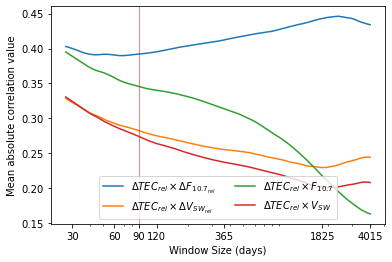

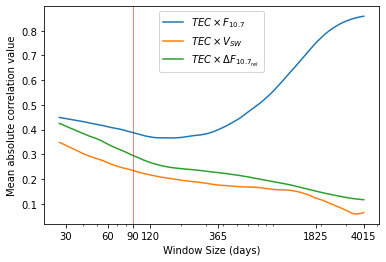

In [276]:
from IPython.display import display, Latex




fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])


for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['relTEC_relF10'], label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
ax.plot(meanCorrelation['relTEC_relSWS'], label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
ax.plot(meanCorrelation['relTEC_F10'], label=r'$\Delta TEC_{rel} \times F_{10.7}$')
ax.plot(meanCorrelation['relTEC_SWS'], label=r'$\Delta TEC_{rel} \times V_{SW}$')
ax.axvline(90, color='red', linewidth=0.5)
# ax.set_title(r'Mean absolute correlation of $\Delta TEC_{rel}$ at '+ str(loc[0])+'N '+str(loc[1])+'E')
ax.set_xlabel('Window Size (days)')
ax.legend(loc = "lower center", ncol=2)
fig.savefig('mean_abs_corr_rel_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150, bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())


ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['tec_f10'], label=r'$ TEC \times F_{10.7}$')
ax.plot(meanCorrelation['tec_sws'], label=r'$ TEC \times V_{SW}$')
ax.plot(meanCorrelation['tec_relF10'], label=r'$ TEC \times \Delta F_{10.7_{rel}}$')
ax.axvline(90, color='red', linewidth=0.5)
ax.set_xlabel('Window Size (days)')
# ax.set_title('Mean absolute correlation of TEC at {}N {}E'.format(loc[0], loc[1]))
ax.legend()


fig.savefig('mean_abs_corr_pure_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150, bbox_inches='tight')
plt.show()

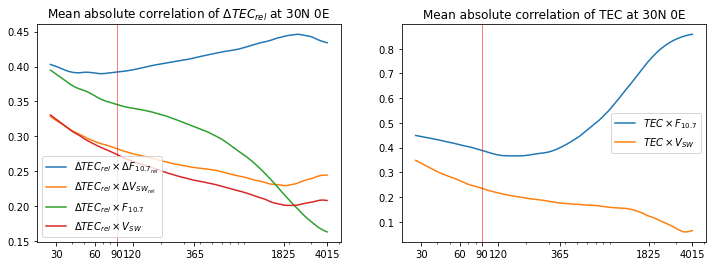

In [241]:
from IPython.display import display, Latex

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 4)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xticks([30, 60, 90, 120, 365, 1825, 4015])
# ax[0].set_ylim([0.05, 0.35])

ax[1].set_xticks([30, 60, 90, 120, 365, 1825, 4015])

for axis in [ax[0].xaxis, ax[0].yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
for axis in [ax[1].xaxis, ax[1].yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax[0].plot(meanCorrelation['relTEC_relF10'], label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
ax[0].plot(meanCorrelation['relTEC_relSWS'], label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
ax[0].plot(meanCorrelation['relTEC_F10'], label=r'$\Delta TEC_{rel} \times F_{10.7}$')
ax[0].plot(meanCorrelation['relTEC_SWS'], label=r'$\Delta TEC_{rel} \times V_{SW}$')
ax[0].axvline(90, color='red', linewidth=0.5)
ax[0].set_title(r'Mean absolute correlation of $\Delta TEC_{rel}$ at {}N {}E'.format(loc))

ax[1].plot(meanCorrelation['tec_f10'], label=r'$ TEC \times F_{10.7}$')
ax[1].plot(meanCorrelation['tec_sws'], label=r'$ TEC \times V_{SW}$')
ax[1].axvline(90, color='red', linewidth=0.5)
ax[1].set_title('Mean absolute correlation of TEC at 30N 0E')
ax[0].legend()
ax[1].legend()
fig.savefig('mean_abs_corr_tec_30N_0E.pdf', dpi=150)
plt.show()

In [ ]:
def meanAbsolute(data):
    mean = data.mean().values[0]
    dataMean = (data - mean).mean().values[0]
    return dataMean

lat             60.0
lon                0
date                
1997-01-01       NaN
1997-01-02       NaN
1997-01-03       NaN
1997-01-04       NaN
1997-01-05       NaN
...              ...
2020-12-27  3.854167
2020-12-28  4.070833
2020-12-29  3.791667
2020-12-30  3.891667
2020-12-31  3.537500

[8766 rows x 1 columns]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
1

1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005


3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648


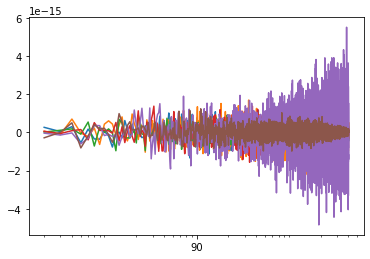

In [165]:
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"
tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\tec\\"

f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
tec = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\"

tecRelDiffData = pd.DataFrame()
tecData = pd.DataFrame()
loc = (60, 0)
for year in analysisPeriod:
    tec_rel_diff_path = tec_rel_diff + '{}.h5'.format(year)
    temptecRelDiffData = readH5File(tec_rel_diff_path)[[loc]].interpolate()
    tecRelDiffData = tecRelDiffData.append(temptecRelDiffData)
    
    
    tec_path = tec + '{}.h5'.format(year)
    temptecData = readH5File(tec_path)[[loc]].interpolate()
    tecData = tecData.append(temptecData)
    
    
    
tecRelDiffData = tecRelDiffData.groupby(level = ['date'], axis = 0).mean()
tecData = tecData.groupby(level = ['date'], axis = 0).mean()
print(tecData)







F10Data = readH5File(f10).interpolate()
F10RelDiffData = readH5File(f10_7_rel_diff).interpolate()
swsData = readH5File(sws).interpolate()
swsRelDiffData = readH5File(sws_rel_diff).interpolate()












meanCorrelation = pd.DataFrame(columns=['window_size', 'relTEC_relSWS', 'relTEC_relF10', 'relTEC_SWS', 'relTEC_F10', 'tec_f10', 'tec_sws'])

for windowSize in np.arange(1, 4015):
    
    print(windowSize)
    
    correlation_relTEC_relSWS = tecRelDiffData.rolling(windowSize).corr(swsRelDiffData['sws']).shift(int(windowSize/2)*-1)
    correlation_relTEC_relSWS = meanAbsolute(correlation_relTEC_relSWS)
    
    
    correlation_relTEC_relF10 = tecRelDiffData.rolling(windowSize).corr(F10RelDiffData['f10_7']).shift(int(windowSize/2)*-1)
    correlation_relTEC_relF10 = meanAbsolute(correlation_relTEC_relF10)
    
    
    correlation_relTEC_SWS = tecRelDiffData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1)
    correlation_relTEC_SWS = meanAbsolute(correlation_relTEC_SWS)
    
    
    correlation_relTEC_F10 = tecRelDiffData.rolling(windowSize).corr(F10Data['f10_7']).shift(int(windowSize/2)*-1)
    correlation_relTEC_F10 = meanAbsolute(correlation_relTEC_F10)
    
    
    correlation_tec_sws = tecData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1)
    correlation_tec_sws = meanAbsolute(correlation_tec_sws)
    
    
    correlation_tec_f10 = tecData.rolling(windowSize).corr(F10Data['f10_7']).shift(int(windowSize/2)*-1)
    correlation_tec_f10 = meanAbsolute(correlation_tec_f10)
    
    
    
    row = {'window_size': windowSize, 
               'relTEC_relSWS': correlation_relTEC_relSWS, 
               'relTEC_relF10': correlation_relTEC_relF10,
               'relTEC_SWS': correlation_relTEC_SWS,
               'relTEC_F10': correlation_relTEC_F10,
               'tec_f10': correlation_tec_f10, 
               'tec_sws': correlation_tec_sws
          }
#     print(row)
    meanCorrelation = meanCorrelation.append(row, ignore_index=True) 
    
meanCorrelation = meanCorrelation.set_index('window_size')

print(meanCorrelation)













from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots()
plt.xscale("log")
ax.set_xticks([90])

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.plot(meanCorrelation)
plt.show()




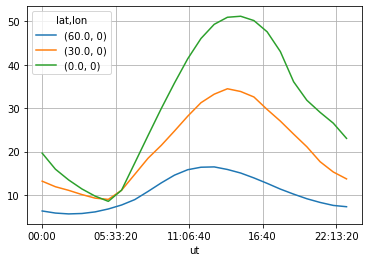

lat            60.0
lon               0
ut         00:00:00
date               
1997-01-01      NaN
1997-01-02      NaN
1997-01-03      NaN
1997-01-04      NaN
1997-01-05      NaN
...             ...
2020-12-27      2.1
2020-12-28      2.7
2020-12-29      3.2
2020-12-30      3.0
2020-12-31      2.9

[8766 rows x 1 columns]


C:\Users\davi_fr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


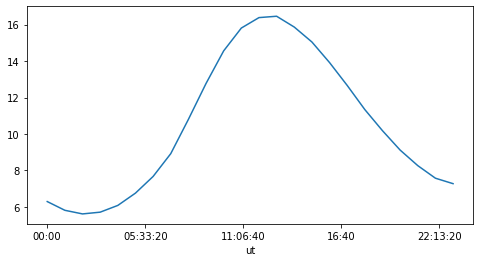

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->block0_items_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle

-------------------
-------------------
-------------------


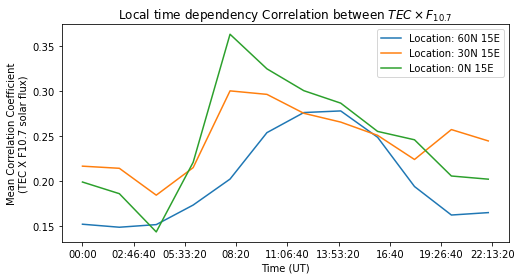

C:\Users\davi_fr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


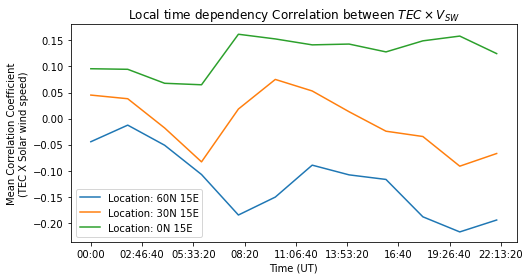

In [443]:
from scipy.signal import savgol_filter
location = [(60, 0), (30, 0), (0, 0)]
# location = [60, 30, 0]
param = ['f10', 'sws']

windowSize = 90
# tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
# sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
# f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"


tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\append\\tec\\tec.h5"
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"
f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"


f10_7_rel_diff = readH5File(f10_7_rel_diff_file)
f10_7Data = readH5File(f10)
f10_7_rel_diff = f10_7Data
f10_7_rel_diff.index = pd.to_datetime(f10_7_rel_diff.index)
# print(f10_7_rel_diff.dtypes)
swsData = readH5File(sws_rel_diff)
swspureData = readH5File(sws)
swsData = swspureData
swsData.index = pd.to_datetime(swsData.index)
tecDataFull = pd.DataFrame()


for year in analysisPeriod:
    tecPath = 'C:/Users/davi_fr/Documents/Thesis Project Final/correlation_analysis_01122022/computations/relative_difference/tec/' + str(year) + '.h5'
    tecPath = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\" + str(year) + '.h5'
    tecData = readH5File(tecPath)[location]
#     tecData = tecData.groupby(level = 'lat', axis =1).mean()
    tecDataFull = tecDataFull.append(tecData)
#     print(tecData)
    
    
tecDataFull = tecDataFull.interpolate()


# tecDataFull = tecDataFull.rolling(2, min_periods = 1).mean().shift(-1)
# print(tecDataFull)
# print(tecDataFull.groupby(level='ut', axis=0).mean())
tecDataFull.groupby(level='ut', axis=0).mean().plot()
plt.grid()
plt.show()

tecDataFull = tecDataFull.unstack()

# tecDataFull[tecDataFull.columns[0]].plot()
# tecDataFull[tecDataFull.columns[23]].plot()
# plt.show()

# tecDataFull[tecDataFull.columns[23]].plot()
# tecDataFull[tecDataFull.columns[0]].plot()
# plt.show()


# tecDataFull.to_csv('time.csv')
# print(tecDataFull)
# tecDataFullMa_27 = tecDataFull.rolling(27, min_periods=12).mean().shift(int(27/2)*-1)
# tecDataFullRelDiff = ((tecDataFull - tecDataFullMa_27)/tecDataFullMa_27)*100
# print(tecDataFullRelDiff)

# tecDataFullRelDiff[(60, 15)].plot(figsize=(8,3))



# tecDataFull = tecDataFullRelDiff


# tecDataFull = tecDataFull.unstack()
print(tecDataFull[[tecDataFull.columns[0]]])



figuresize = (8,4)

# tecDataFull = tecDataFull.unstack()
tecDataFull.index = pd.to_datetime(tecDataFull.index)

tecDataFull[location[0]].mean().plot(figsize=figuresize)
plt.show()
# print(tecDataFull)    

min_period = 27
for par in param:
    if par == 'f10':
        correlation_tec_f10_period = tecDataFull.rolling(windowSize, min_periods = min_period).corr(f10_7_rel_diff['f10_7']).shift(int(windowSize/2)*-1)
        correlation_tec_f10_period = extractDataByIndexDate(correlation_tec_f10_period, '1998-01-01', '2020-12-31')
#         print(correlation_tec_f10_period[correlation_tec_f10_period.columns[0::2]])
        correlation_tec_f10_period = correlation_tec_f10_period[correlation_tec_f10_period.columns[0::2]]
        correlation_tec_f10_period.to_hdf('correlation_tec_f10_loc_60_30_0_15_ut.h5', key='df')



    if par == 'sws':
        
        correlation_tec_sws_period = tecDataFull.rolling(windowSize, min_periods = min_period).corr(swsData['sws']).shift(int(windowSize/2)*-1)
        correlation_tec_sws_period = extractDataByIndexDate(correlation_tec_sws_period, '1998-01-01', '2020-12-31')
        correlation_tec_sws_period = correlation_tec_sws_period[correlation_tec_sws_period.columns[0::2]]
        correlation_tec_sws_period.to_hdf('correlation_tec_sws_loc_60_30_0_15_ut.h5', key='df')
        

    
            

        
        
sdate = '1998-01-01'
edate = '2020-12-31'
        
        
        
        
corr_f10_ut = readH5File('correlation_tec_f10_loc_60_30_0_15_ut.h5')[sdate:edate]


meanCorrUt = pd.DataFrame()


for j in np.arange(len(location)):
    loc = location[j]
    dataAtLoc = corr_f10_ut[loc].T
    print('-------------------')
#     print(dataAtLoc[dataAtLoc.columns[0]])
#     corr_f10_ut[loc][corr_f10_ut[loc].columns[0]].plot(figsize=(10,3))
#     corr_f10_ut[loc][corr_f10_ut[loc].columns[23]].plot(figsize=(10,3))
    plt.show()
    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)


    
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = figuresize, 
                ylabel = 'Mean Correlation Coefficient\n(TEC X F10.7 solar flux)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
x = np.arange(0,24, 1)
# ax.set_xticks(meanCorrUt.index[::2])
# ax.set_xticklabels(x[::2])
ax.set_title(r'Local time dependency Correlation between $TEC \times F_{10.7}$')
# ax.set_ylim([-0.6, 0.6])
plt.savefig(final_plot_location + 'mean_correlation_tec_f10_ut_lat_lon_15E'+feature+'.pdf', bbox_inches = 'tight')

plt.show()





feature = 'pure'



# location = [(60, 15), (30, 15), (0, 15)]
corr_f10_ut = readH5File('correlation_tec_sws_loc_60_30_0_15_ut.h5')[sdate:edate]


meanCorrUt = pd.DataFrame()
for j in np.arange(len(location)):
    loc = location[j]
    
#     corr_f10_ut[loc][corr_f10_ut[loc].columns[0]].plot(figsize=(10,3))
#     corr_f10_ut[loc][corr_f10_ut[loc].columns[23]].plot(figsize=(10,3))
    
    dataAtLoc = corr_f10_ut[loc].T
    plt.show()
    
    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)
        
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = figuresize, 
                ylabel = 'Mean Correlation Coefficient\n(TEC X Solar wind speed)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
ax.set_title(r'Local time dependency Correlation between $TEC \times V_{SW}$')
x = np.arange(0,24, 1)
# ax.set_xticks(meanCorrUt.index[::2])
# ax.set_xticklabels(x[::2])
# ax.set_ylim([-0.6, 0.6])
# ax.set_ylim([-0.6, 0.6])

plt.savefig(final_plot_location + 'mean_correlation_tec_sws_ut_lat_lon_15E'+feature+'.pdf', bbox_inches = 'tight')
plt.show()